# Read output files

In [2]:
import awkward as ak
import numpy as np
import os, uproot

In [21]:
basedir = {
    year: {
        'TT': [f'../condor/output/mc/{year}/{channel}/' for channel in ['TTJets']],
        'W+jets': [f'../condor/output/mc/{year}/{channel}/' for channel in ['WJetsToQQ', 'WJetsToLNu']],
    } for year in ['2016pre', '2016post', '2017', '2018']
}


BKG = set([k for k in basedir['2017'].keys() if not (r'H\gamma' in k or k=='data')])
SIG_COLOR = {
    r'$Z^\mathrm{\prime}$(1000)$\to H(bb)\gamma$': 'red',
    r'$Z^\mathrm{\prime}$(2000)$\to H(bb)\gamma$': 'blue',
    r'$Z^\mathrm{\prime}$(3000)$\to H(bb)\gamma$': 'gold',
}

filepath={year: {c: [] for c in basedir[year]} for year in basedir}
for year, paths in basedir.items():
    for mc, folders in paths.items():
        for folder in folders:
            for (current_path, dirs, files) in os.walk(folder):
                for f in files:
                    if f.endswith('.parq') and '-' not in f:
                        filepath[year][mc].append(os.path.join(current_path, f))

In [22]:
events = {year: {k: [] for k in filepath[year]} for year in filepath}
for year in filepath:
    for k, v in filepath[year].items():
        for f in v:
            if os.path.getsize(f) == 0 or len(ak.from_parquet(f))==0:
                continue
            array = ak.from_parquet(f)
            if len(array)>0:
                events[year][k].append(array)
        if len(events[year][k]) > 0:
            events[year][k] = ak.concatenate(events[year][k], axis=0)

events['Run2'] = {k: ak.concatenate([events[y][k] for y in events], axis=0) for k in events['2017']}
events = {y: {k: events[y][k][events[y][k]['m_85']<15] for k in events[y]} for y in events}


weight={y: {c: events[y][c].event_final_weight for c in events[y] if c!='data' and len(events[y][c])>0} for y in events}

# Start plotting

In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = True ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=False):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return np.abs(h), var

def error_bar(h, var, mode='data'):
    from scipy.interpolate import CubicSpline
    
    h, var = np.array(h), np.array(var)
    if mode == 'data':
        number = h
    elif mode == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = np.nan_to_num(h**2/var, nan=0)
    else:
        raise ValueError("mode should be 'data' or 'mc'! ")
    center = range(11)
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0) & (number<=10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    
    if mode == 'mc':
        up_error_bar *= np.nan_to_num(var/h, nan=1)
        down_error_bar *= np.nan_to_num(var/h, nan=1)

    return np.array([down_error_bar, up_error_bar])

## Data comparison

In [11]:
def data_compare_plot(arrays, plot_name: str, x_name: str, cuts=None, bins=40, x_min=0, x_max=3000, density=True, overflow=True, underflow=False):
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}

    ## canvas initializing
    # colorlist=['red', 'blue', 'green', 'black', 'cyan', 'darkorange', 'darkviolet', 'SlateGray', 'HotPink', 'LightSkyBlue']
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=colorlist)
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 9))
    ax=plt.gca()
    plt.grid()
    hep.cms.label(data=True, ax=ax, fontsize=18)
    
    ## analyze

        
    ## plot
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=['red', 'blue', 'green', 'darkorange', 'cyan', 'HotPink', 'darkviolet', 'SlateGray', 'black', 'LightSkyBlue'])
    for (k, v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        hist.fill(v)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        hep.histplot(h, bins=hist.axes[0].edges, xerr=bin_width/2, yerr=error_bar(h, var, mode='data'), label=k, histtype='step', density=density, stack=False, ax=ax, linewidth=2)
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too) 

    ## axises
    ax.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax.set_xlim(x_min, x_max)
    if 'eta' in plot_name:
        ax.set_ylim(1e-2, ax.get_ylim()[1]*5)
    else:
        ax.set_ylim(1e-8, ax.get_ylim()[1]*5)
    ax.set_yscale('log')
    #ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    #x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    #y_major_locator=MultipleLocator(1)
    #ax.xaxis.set_major_locator(x_major_locator)
    #ax.yaxis.set_major_locator(y_major_locator)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=2, frameon=False, fontsize=18)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/data_compare_{plot_name}{suffix}.pdf", bbox_inches='tight')
    plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


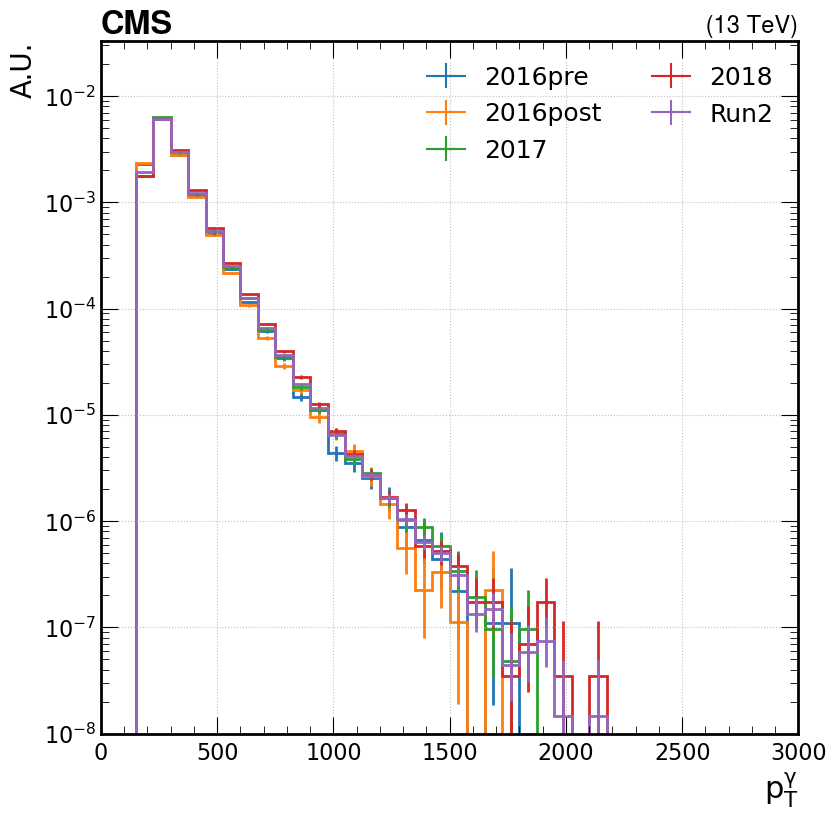

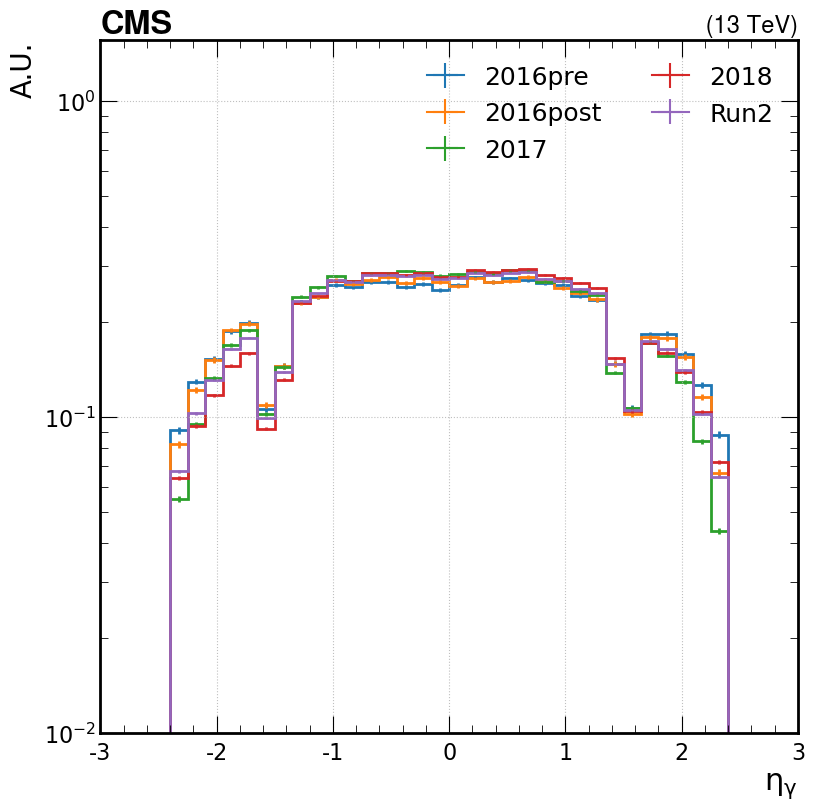

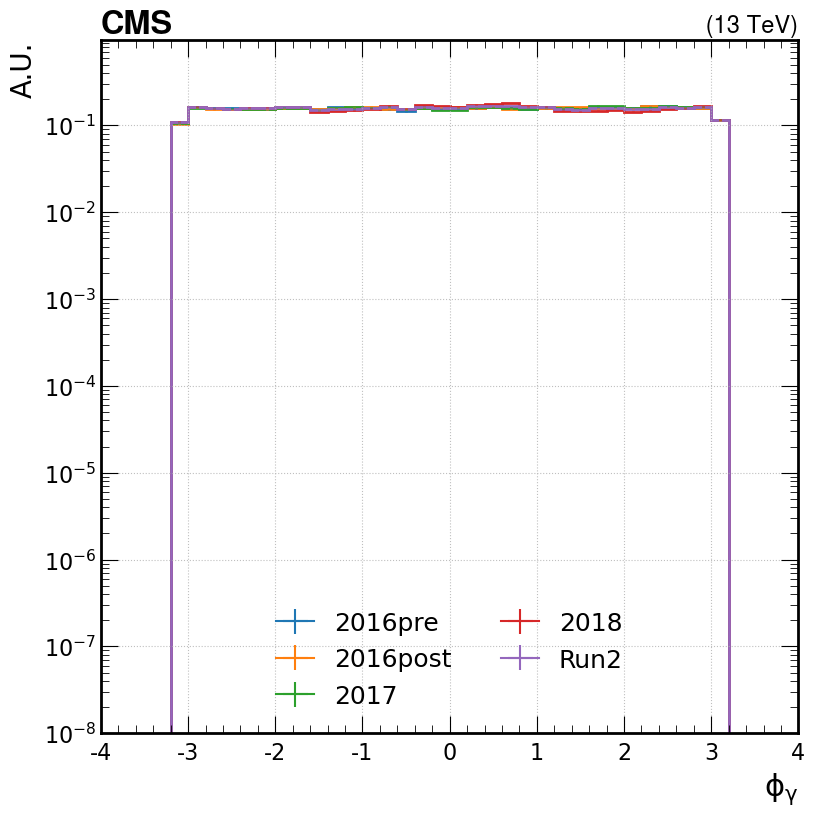

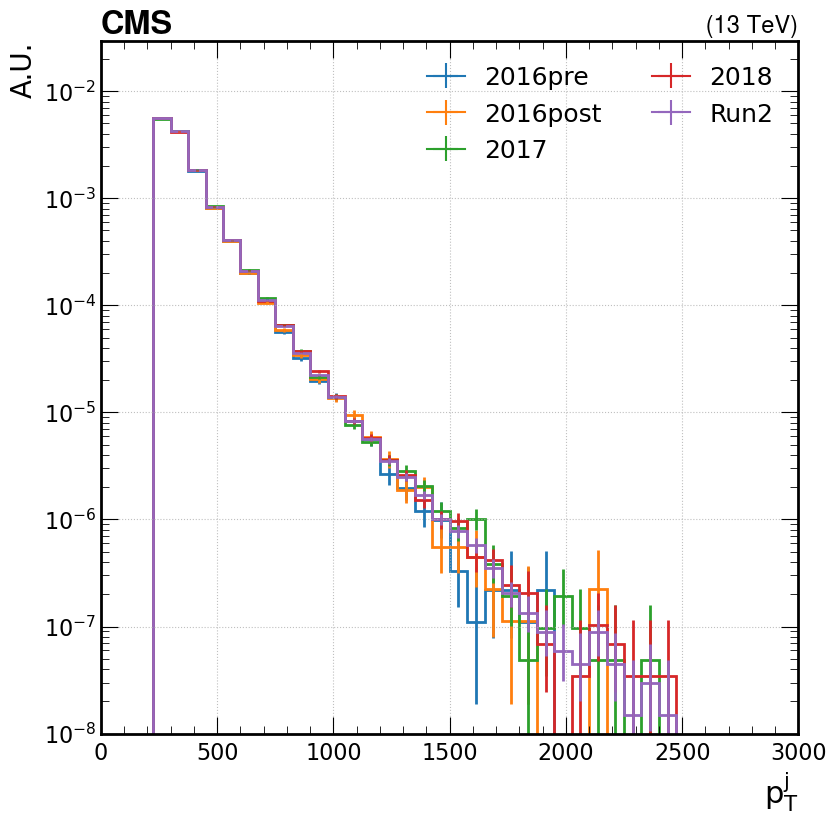

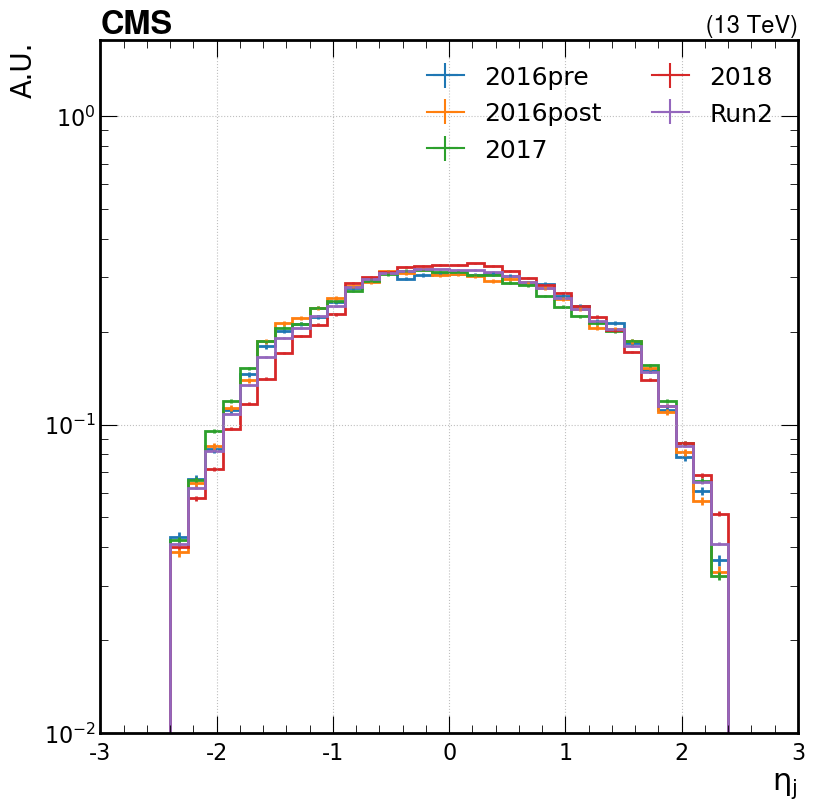

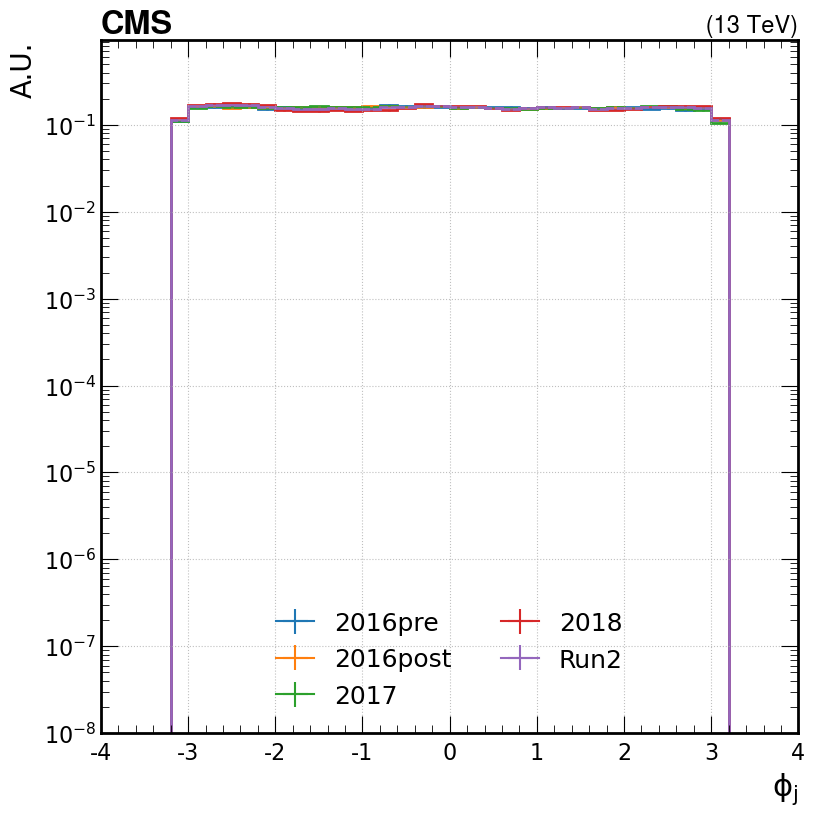

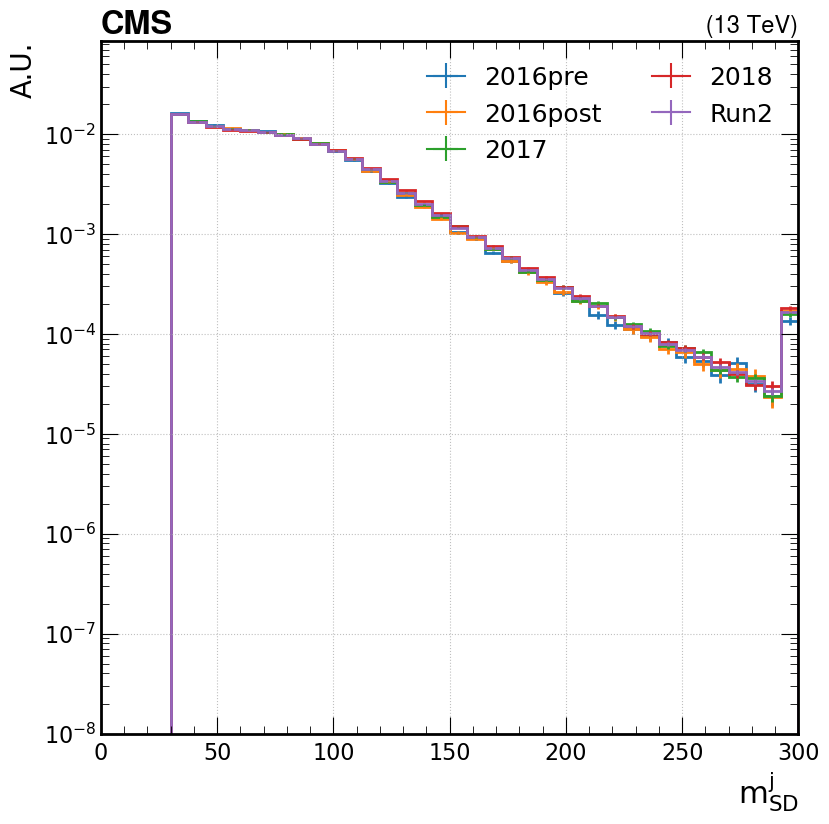

In [12]:
arrays={k: events[k]['data'].photon_pt for k in events}
data_compare_plot(arrays, 'photon_pt', x_name=r'$p_T^{\gamma}$')

arrays={k: events[k]['data'].photon_eta for k in events}
data_compare_plot(arrays, 'photon_eta', x_name=r'$\eta_{\gamma}$', x_min=-3, x_max=3)

arrays={k: events[k]['data'].photon_phi for k in events}
data_compare_plot(arrays, 'photon_phi', x_name=r'$\phi_\gamma$', x_min=-4, x_max=4)

arrays={k: events[k]['data'].AK8jet_pt for k in events}
data_compare_plot(arrays, 'AK8jet_pt', x_name=r'$p_T^j$')

arrays={k: events[k]['data'].AK8jet_eta for k in events}
data_compare_plot(arrays, 'AK8jet_eta', x_name=r'$\eta_j$', x_min=-3, x_max=3)

arrays={k: events[k]['data'].AK8jet_phi for k in events}
data_compare_plot(arrays, 'AK8jet_phi', x_name=r'$\phi_j$', x_min=-4, x_max=4)

arrays={k: events[k]['data'].AK8jet_msoftdrop for k in events}
data_compare_plot(arrays, 'AK8jet_msoftdrop', x_name=r'$m_{SD}^j$', x_min=0, x_max=300)

## LHEScaleWeight study

In [53]:
from matplotlib.cm import get_cmap

hep.style.use("CMS")
#mpl.rcParams['axes.prop_cycle'] = cycler(color=get_cmap("tab20").colors)
#print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

def plot_LHEScaleWeight(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, log_y=True, x_axis=None):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    LUMI["Run2"] = np.sum(list(LUMI.values()))
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)
    ax, ax1 = f.add_subplot(gs[0]), f.add_subplot(gs[1])
    ax.grid(); ax1.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    
    
    ## analyze
    histogram = {}
    variance = {}
    
    for (k,v) in arrays.items():
        if x_axis is None:
            hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        else:
            hist = bh.Histogram(x_axis, storage=bh.storage.Weight())
        if 'delta_phi' in plot_name:
            values = np.min([v, 2*np.pi-v], axis=0)
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        
        histogram[k] = h
        variance[k] = var
        
    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    for (k, h) in histogram.items():
        if k == 'nominal':
            continue
        err = np.sqrt(variance[k])
        hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=density, stack=False, linewidth=2, ax=ax)
        ratio_err = err/histogram['nominal']
        hep.histplot(h/histogram['nominal'], bins=hist.axes[0].edges, yerr=ratio_err, label=k, histtype='step', density=density, stack=False, linewidth=2, ax=ax1)
    k='nominal'
    err = np.sqrt(variance[k])
    hep.histplot(histogram[k], bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=density, stack=False, linewidth=2, ax=ax, color='black')

    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(1e-3 if log_y else 0, ax.get_ylim()[1]*(3e2 if log_y else 1.2))
    if log_y:
        ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    #ax1.set_xticklabels([])
    ax1.set_ylim(0, 2)
    ax1.set_xlabel(x_name, fontsize=20)
    ax1.set_ylabel('Ratio', ha='center', fontsize=20)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=15)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists(f'./plots/{year}'):
        os.makedirs(f'./plots/{year}')
    plt.savefig(f"./plots/{year}/{plot_name}{suffix}.pdf", bbox_inches='tight')
    plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

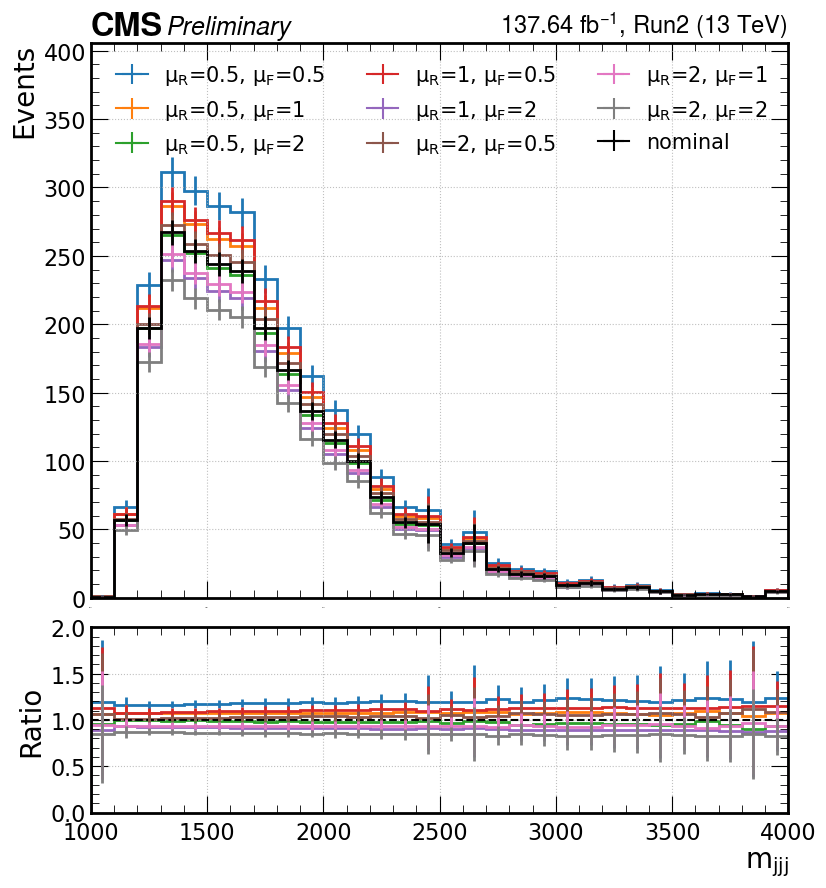

In [54]:
year = 'Run2'
channel = 'W+jets'

arrays={
    r'$\mu_R$=0.5, $\mu_F$=0.5': events[year][channel]['gKK_mass'],
    r'$\mu_R$=0.5, $\mu_F$=1': events[year][channel]['gKK_mass'],
    r'$\mu_R$=0.5, $\mu_F$=2': events[year][channel]['gKK_mass'],
    r'$\mu_R$=1, $\mu_F$=0.5': events[year][channel]['gKK_mass'],
    'nominal': events[year][channel]['gKK_mass'],
    r'$\mu_R$=1, $\mu_F$=2': events[year][channel]['gKK_mass'],
    r'$\mu_R$=2, $\mu_F$=0.5': events[year][channel]['gKK_mass'],
    r'$\mu_R$=2, $\mu_F$=1': events[year][channel]['gKK_mass'],
    r'$\mu_R$=2, $\mu_F$=2': events[year][channel]['gKK_mass'],
}

_weight={
    r'$\mu_R$=0.5, $\mu_F$=0.5': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 0],
    r'$\mu_R$=0.5, $\mu_F$=1': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 1],
    r'$\mu_R$=0.5, $\mu_F$=2': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 2],
    r'$\mu_R$=1, $\mu_F$=0.5': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 3],
    'nominal': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 4],
    r'$\mu_R$=1, $\mu_F$=2': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 5],
    r'$\mu_R$=2, $\mu_F$=0.5': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 6],
    r'$\mu_R$=2, $\mu_F$=1': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 7],
    r'$\mu_R$=2, $\mu_F$=2': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 8],
}
plot_LHEScaleWeight(arrays, x_name=r'$m_{jjj}$', plot_name='gKK_mass_Wjets', x_min=1000, x_max=4000, bins=30, weight=_weight, year=year, log_y=False)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

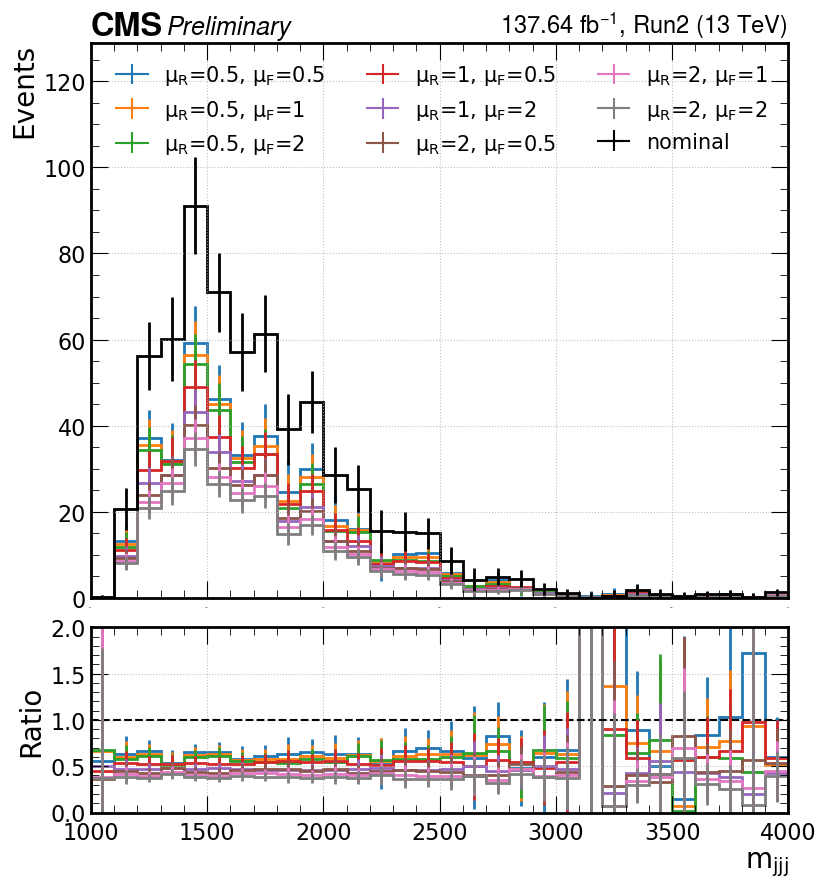

In [55]:
year = 'Run2'
channel = 'TT'

arrays={
    r'$\mu_R$=0.5, $\mu_F$=0.5': events[year][channel]['gKK_mass'],
    r'$\mu_R$=0.5, $\mu_F$=1': events[year][channel]['gKK_mass'],
    r'$\mu_R$=0.5, $\mu_F$=2': events[year][channel]['gKK_mass'],
    r'$\mu_R$=1, $\mu_F$=0.5': events[year][channel]['gKK_mass'],
    'nominal': events[year][channel]['gKK_mass'],
    r'$\mu_R$=1, $\mu_F$=2': events[year][channel]['gKK_mass'],
    r'$\mu_R$=2, $\mu_F$=0.5': events[year][channel]['gKK_mass'],
    r'$\mu_R$=2, $\mu_F$=1': events[year][channel]['gKK_mass'],
    r'$\mu_R$=2, $\mu_F$=2': events[year][channel]['gKK_mass'],
}

_weight={
    r'$\mu_R$=0.5, $\mu_F$=0.5': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 0],
    r'$\mu_R$=0.5, $\mu_F$=1': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 1],
    r'$\mu_R$=0.5, $\mu_F$=2': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 2],
    r'$\mu_R$=1, $\mu_F$=0.5': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 3],
    'nominal': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 4],
    r'$\mu_R$=1, $\mu_F$=2': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 5],
    r'$\mu_R$=2, $\mu_F$=0.5': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 6],
    r'$\mu_R$=2, $\mu_F$=1': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 7],
    r'$\mu_R$=2, $\mu_F$=2': weight[year][channel]*events[year][channel]['event_LHEScaleWeight'][:, 8],
}
plot_LHEScaleWeight(arrays, x_name=r'$m_{jjj}$', plot_name='gKK_mass_TT', x_min=1000, x_max=4000, bins=30, weight=_weight, year=year, log_y=False)

## $MET/p_T$ study

In [16]:
import plotly.express as px
import pandas as pd

y='2018'
arrays={k: events[y][k].event_MET_pt/events[y][k].AK8jet_pt for k in events[y]}
low={k: ak.sum(arrays[k]<0.3) for k in arrays}
medium={k: ak.sum((arrays[k]>0.3)&(arrays[k]<0.6)) for k in arrays}
high={k: ak.sum(arrays[k]>0.6) for k in arrays}

df = pd.DataFrame({
    'component': [k for k in arrays if k not in ['data', 'Zp(2TeV)ToHG']], 
    'MET/p_T^j<0.3': [ak.sum((arrays[k]<0.3)*weight['2018'][k]) for k in arrays if k not in ['data', 'Zp(2TeV)ToHG']],
    '0.3<MET/p_T^j<0.6': [ak.sum(((arrays[k]>0.3)&(arrays[k]<0.6))*weight['2018'][k]) for k in arrays if k not in ['data', 'Zp(2TeV)ToHG']],
    'MET/p_T^j>0.6': [ak.sum((arrays[k]>0.6)*weight['2018'][k]) for k in arrays if k not in ['data', 'Zp(2TeV)ToHG']],
})

fig = px.pie(df, values='MET/p_T^j<0.3', names='component', color='component', title='MET/p_T(j)<0.3')
fig.update_layout(autosize=False, width=600, height=500,margin=dict(l=20, r=20, t=40, b=20),)
fig.show()
#fig.write_image('./plots/low.png')
fig = px.pie(df, values='0.3<MET/p_T^j<0.6', names='component', color='component', title='0.3<MET/p_T(j)<0.6')
fig.update_layout(autosize=False, width=600, height=500,margin=dict(l=20, r=20, t=40, b=20),)
fig.show()
#fig.write_image('./plots/medium.png')
fig = px.pie(df, values='MET/p_T^j>0.6', names='component', color='component', title='MET/p_T(j)>0.6')
fig.update_layout(autosize=False, width=600, height=500,margin=dict(l=20, r=20, t=40, b=20),)
fig.show()
#fig.write_image('./plots/high.png')

In [17]:
"""
arrays = {k: events['2018'][k]['photon-jet_mass'] for k in events['2018']}
for k in set(arrays.keys()):
    if k.startswith('Zp'):
        arrays[k.replace('HG', 'H(WW)G')] = arrays[k][
            events['2018'][k]['gen_ZpToH(WW)Gamma'] & 
            (events['2018'][k].event_MET_pt/events['2018'][k].AK8jet_pt > 0.6)
        ]
        weight['2018'].update({
            k.replace('HG', 'H(WW)G'): events['2018'][k].event_weight[
                events['2018'][k]['gen_ZpToH(WW)Gamma'] & 
                (events['2018'][k].event_MET_pt/events['2018'][k].AK8jet_pt > 0.6)
            ]
        })
        del arrays[k]
    else:
        arrays[k] = arrays[k][
            (events['2018'][k].event_MET_pt/events['2018'][k].AK8jet_pt > 0.6)
        ]
        if k=='data':
            continue
        weight['2018'].update({
            k: events['2018'][k].event_weight[
                (events['2018'][k].event_MET_pt/events['2018'][k].AK8jet_pt > 0.6)
            ]
        })
        
        
data_mc_compare_plot(arrays, plot_name='high_MET_photon-jet_mass', x_name=r'$m_{j\gamma}$', x_max=3500, bins=35, weight=weight['2018'], year='2018', density=False)
data_mc_compare_plot(arrays, plot_name='high_MET_photon-jet_mass', x_name=r'$m_{j\gamma}$', x_max=3500, bins=35, weight=weight['2018'], year='2018', density=True)
"""

"\narrays = {k: events['2018'][k]['photon-jet_mass'] for k in events['2018']}\nfor k in set(arrays.keys()):\n    if k.startswith('Zp'):\n        arrays[k.replace('HG', 'H(WW)G')] = arrays[k][\n            events['2018'][k]['gen_ZpToH(WW)Gamma'] & \n            (events['2018'][k].event_MET_pt/events['2018'][k].AK8jet_pt > 0.6)\n        ]\n        weight['2018'].update({\n            k.replace('HG', 'H(WW)G'): events['2018'][k].event_weight[\n                events['2018'][k]['gen_ZpToH(WW)Gamma'] & \n                (events['2018'][k].event_MET_pt/events['2018'][k].AK8jet_pt > 0.6)\n            ]\n        })\n        del arrays[k]\n    else:\n        arrays[k] = arrays[k][\n            (events['2018'][k].event_MET_pt/events['2018'][k].AK8jet_pt > 0.6)\n        ]\n        if k=='data':\n            continue\n        weight['2018'].update({\n            k: events['2018'][k].event_weight[\n                (events['2018'][k].event_MET_pt/events['2018'][k].AK8jet_pt > 0.6)\n            ]\n  

# Optimizing

In [23]:
hep.style.use("CMS")

def signal_window_arrays(arrays: dict, weight: dict, event_cut: dict, bins: int=40, x_min: float=0, x_max: float=2000, overflow: bool=True, underflow: bool=False):
    cut, cut_arrays, cut_weight = {'h': {}, 'var': {}}, {}, {}
    
    for k, array in arrays.items():
        cut_arrays[k] = array[event_cut[k]]
        if k!='data':
            cut_weight[k] = weight[k][event_cut[k]]
    
    for (k, v) in cut_arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        if k!='data':
            hist.fill(values, weight=cut_weight[k])
        else:
            hist.fill(values)
        cut['h'][k], cut['var'][k] = flow(hist=hist, overflow=overflow, underflow=underflow)

    return cut['h'], cut['var']
    

def optimizing_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=40, x_min=0, x_max=2000, density=True, overflow=True, underflow=False, fraction_log=False, mode: str='less'):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        _weight = {k: weight[k][cuts[k]] for k in arrays if k in weight}
        _events = {k: events[year][k][cuts[k]] for k in arrays}
    else:
        _weight = {k: weight[k] for k in arrays if k in weight}
        _events = {k: events[year][k] for k in arrays}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[5, 1], hspace=0.2)
    ax = f.add_subplot(gs[0])
    #ax = plt.gca()
    plt.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax1.grid()
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
 
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        values = ak.fill_none(v, -999)
        
        if k!='data':
            hist.fill(values, weight=_weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var


    ## plot
    # mpl.rcParams['axes.prop_cycle'] = cycler(color=['darkorange', 'cyan', 'HotPink', 'darkviolet', 'SlateGray', 'black', 'LightSkyBlue'])
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=False, stack=True, linewidth=2, ax=ax)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
    
    for (k, h) in individual['h'].items():
        if k=='data':
            err = error_bar(h, individual['var'][k], mode='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=False, stack=False, ax=ax)
        elif k in SIG_COLOR:  # signal
            err = error_bar(h, individual['var'][k], mode='mc')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=False, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            
            ## begin optimizing plot
            mass_center = float(k.split('(')[1][0]) * 1e3
            mass_std = ak.std(_events[k]['photon+jet_mass'], weight=_weight[k])
            cut_h, cut_var = signal_window_arrays(
                arrays=arrays, weight=_weight, event_cut={
                    k: (_events[k]['photon+jet_mass'] > mass_center - 3*mass_std) & (_events[k]['photon+jet_mass'] < mass_center + 3*mass_std) for k in arrays
                }, bins=bins, x_min=x_min, x_max=x_max, overflow=overflow, underflow=underflow
            )
            cut_bkg_h = np.sum([h for k, h in cut_h.items() if k in BKG], axis=0)
            
            if mode=='less':
                y = [ak.sum(cut_h[k][:index]) / np.sqrt(ak.sum(cut_bkg_h[:index]) + 1) for index in range(bins)]
            elif mode=='greater':
                y = [ak.sum(cut_h[k][index:]) / np.sqrt(ak.sum(cut_bkg_h[index:]) + 1) for index in range(bins)]
            y_max_bin = np.argmax(y)
            hep.histplot(y, bins=hist.axes[0].edges, label=k, histtype='step', density=density, stack=False, ax=ax1, color=SIG_COLOR[k], linestyle='dashed')
            #plt.arrow(x=hist.axes[0].edges[y_max_bin], y=np.max(y), dx=0, dy=-np.max(y), length_includes_head=True, color=SIG_COLOR[k])

    ## axises
    ax.set_xlim(x_min, x_max)
    ax.set_xlabel(x_name, fontsize=20, ha='right', x=1)
    # ax.set_xticklabels([])
    ax.set_ylim(1e-3, ax.get_ylim()[1]*1e2)
    ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)    
    ax.set_ylabel('Events', fontsize=20, ha='right', y=1)

    
    #ax1.set_yscale('log')
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(0, ax1.get_ylim()[1]*1.2)
    ax1.tick_params(axis='both', which='major', labelsize=16)
    ax1.set_xlabel('cut_value', fontsize=21, ha='right', x=1)
    ax1.set_ylabel('sensitivity'+('\n(A.U.)' if density else ''), ha='center', fontsize=16)
    ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=15)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists(f'./plots/optimize/{year}'):
        os.makedirs(f'./plots/optimize/{year}')
    plt.savefig(f"./plots/optimize/{year}/{plot_name}{suffix}.pdf", bbox_inches='tight')
    plt.show()

/tmp/ipykernel_1519722/1898494878.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1519722/1898494878.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1519722/1898494878.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1519722/1898494878.p

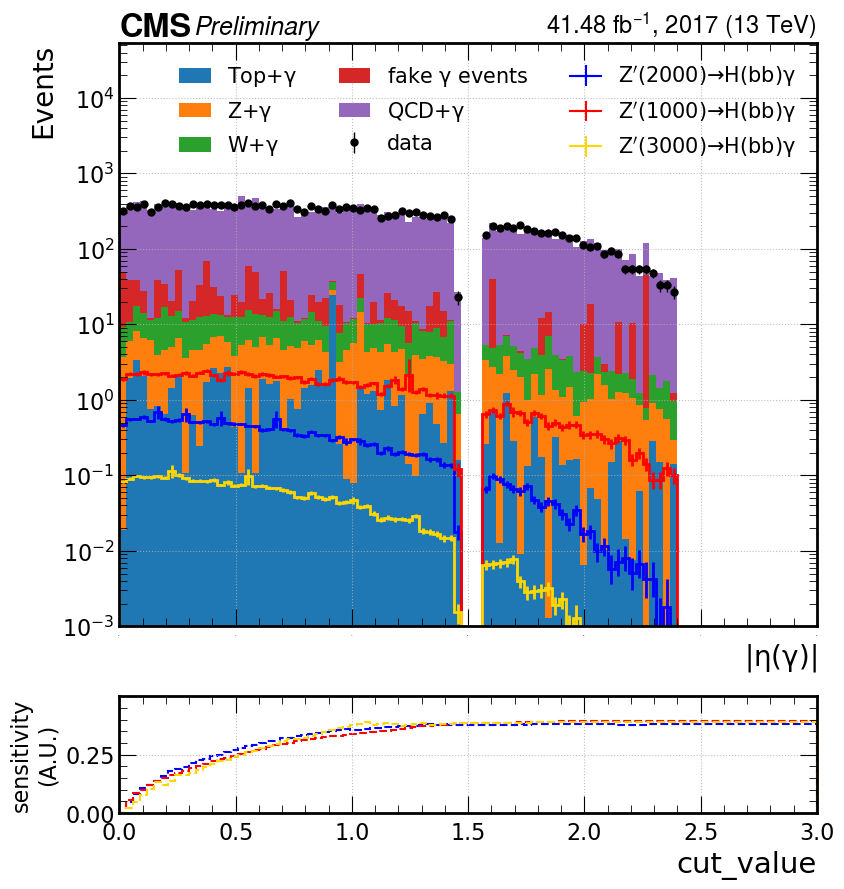

/tmp/ipykernel_1519722/1898494878.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1519722/1898494878.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1519722/1898494878.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1519722/1898494878.p

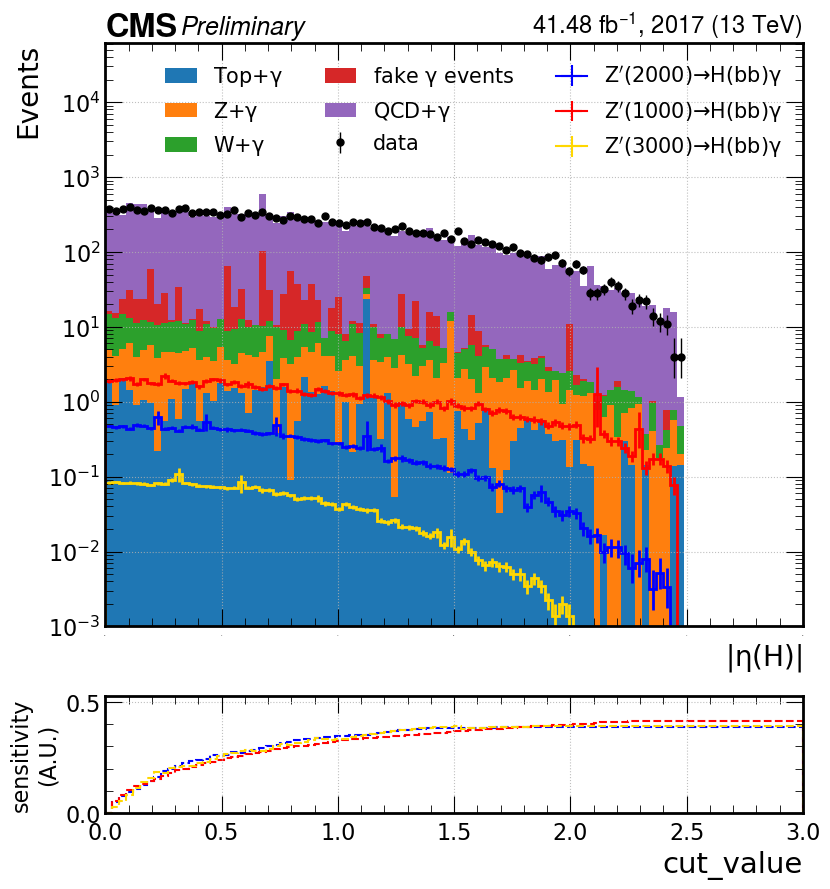

/tmp/ipykernel_1519722/1898494878.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1519722/1898494878.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1519722/1898494878.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1519722/1898494878.p

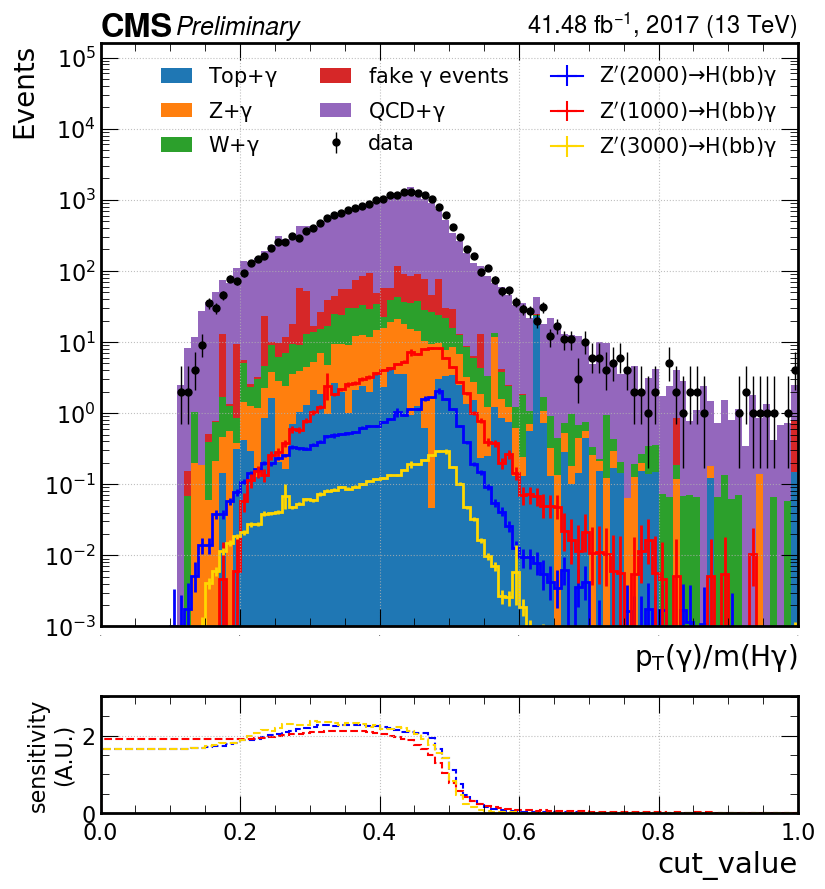

/tmp/ipykernel_1519722/1898494878.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1519722/1898494878.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1519722/1898494878.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1519722/1898494878.p

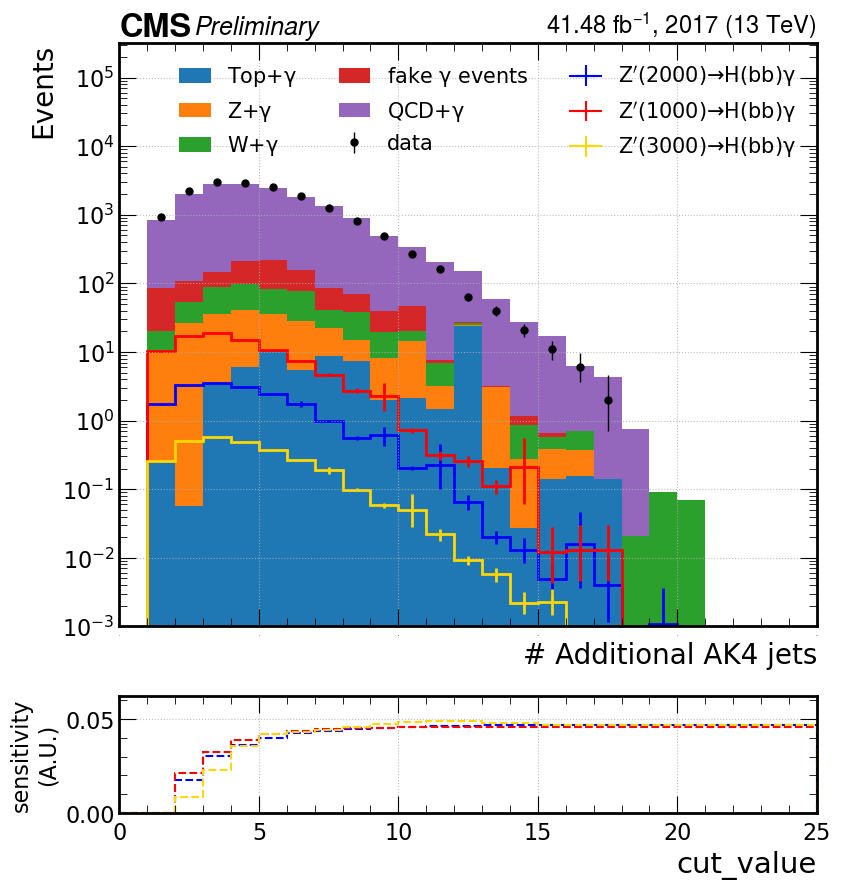

In [24]:
y='2017'
full_cuts = """{
k: ((events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140)) &
(np.abs(events[y][k].photon_eta) < 1.4442) &
(np.abs(events[y][k].AK8jet_eta) < 2.4) &
(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
for k in arrays
}"""

arrays={k: np.abs(events[y][k].photon_eta) for k in events[y]}
optimizing_plot(
    arrays, mode='less', cuts=eval(
        full_cuts.replace("(np.abs(events[y][k].photon_eta) < 1.4442) &", "")
    ), plot_name='abs_photon_eta', x_name=r'$|\eta(\gamma)|$', x_max=3, x_min=0, bins=100, weight=weight[y], year=y
)

arrays={k: np.abs(events[y][k].AK8jet_eta) for k in events[y]}
optimizing_plot(
    arrays, mode='less', cuts=eval(
        full_cuts.replace("(np.abs(events[y][k].AK8jet_eta) < 2.4) &", "")
    ), plot_name='abs_jet_eta', x_name=r'$|\eta(H)|$', x_max=3, x_min=0, bins=100, weight=weight[y], year=y
)

arrays={k: events[y][k].photon_pt/events[y][k]['photon+jet_mass'] for k in events[y]}
optimizing_plot(
    arrays, mode='greater', cuts=eval(
        full_cuts.replace("&\n(events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)", "")
    ), plot_name='photon_pt_over_photon+jet_mass', x_name=r'$p_T(\gamma)/m(H\gamma)$', x_max=1, x_min=0, bins=100, weight=weight[y], year=y
)

arrays={k: events[y][k]['nExtraAK4jet'] for k in events[y]}
optimizing_plot(
    arrays, mode='less', cuts=eval(full_cuts), plot_name='nExtraAK4jet', x_name='# Additional AK4 jets', x_max=25, x_min=0, bins=25, weight=weight[y], year=y
)

/tmp/ipykernel_1519722/415591869.py:59: RuntimeWarning: invalid value encountered in divide
  hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
/tmp/ipykernel_1519722/1898494878.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1519722/1898494878.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:51: RuntimeWarning: invalid value encountered in divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:33: RuntimeWarning: invalid value encountered in divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_1519722/1898494878.py:50: RuntimeWarning: invalid value encountered in divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_1519722/1898494878.py:51: RuntimeWarning: invalid value encounter

$Z^\mathrm{\prime}$(2000)$\to H(bb)\gamma$ [0.         0.05947556 0.07307844 0.0668333  0.05946663 0.04832098
 0.04077607 0.02691074 0.01856458 0.02811025 0.01121652 0.01587452
 0.00534096 0.00257702 0.00243137 0.00116807 0.00586308 0.00175093
 0.         0.0010511  0.         0.         0.         0.
 0.        ]
$Z^\mathrm{\prime}$(1000)$\to H(bb)\gamma$ [0.         0.35166075 0.39012706 0.3508225  0.28824046 0.21323271
 0.1705043  0.12639722 0.09072321 0.10300828 0.03946628 0.02182206
 0.02087634 0.01421235 0.03949313 0.00284677 0.0047912  0.00556889
 0.         0.         0.         0.         0.         0.
 0.        ]
$Z^\mathrm{\prime}$(3000)$\to H(bb)\gamma$ [0.00000000e+00 8.87387349e-03 1.15214526e-02 1.07484890e-02
 9.39984514e-03 7.37037306e-03 6.24901220e-03 5.10903173e-03
 3.28653380e-03 2.65289779e-03 2.73380814e-03 1.53859394e-03
 7.47538539e-04 7.34659122e-04 4.15312730e-04 5.42208719e-04
 5.17983520e-05 0.00000000e+00 1.05416543e-04 0.00000000e+00
 0.00000000e+00 0.00

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Generic family 'sans-serif' not found because none of the foll

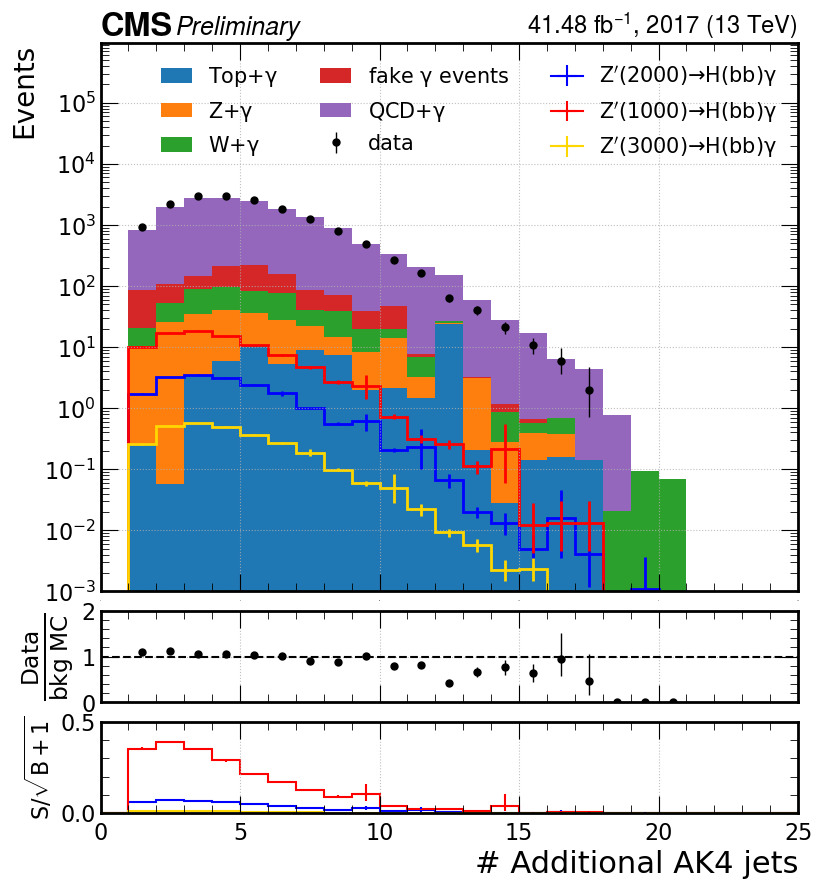

In [26]:
y='2017'
arrays={
    k: events[y][k]['nExtraAK4jet'][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, plot_name='nExtraAK4jet', x_name='# Additional AK4 jets', x_max=25, x_min=0, bins=25, weight=_weight, year=y)

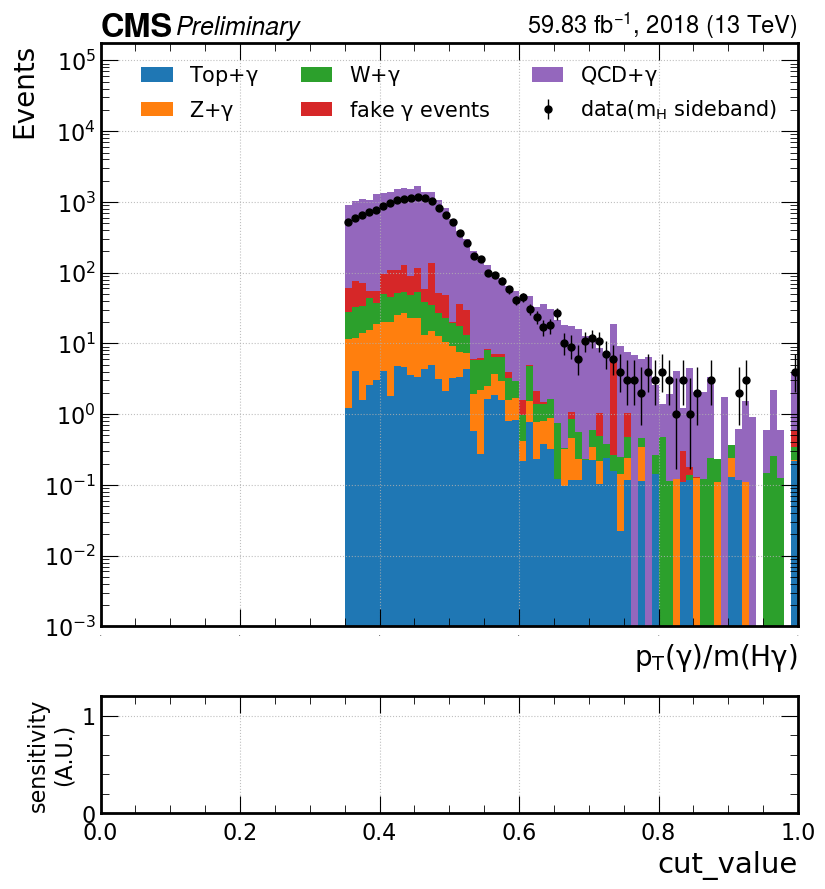

In [20]:
arrays={k: events[y][k].photon_pt/events[y][k]['photon+jet_mass'] for k in events[y]}
optimizing_plot(
    arrays, mode='less', cuts=eval(
        full_cuts.replace(" & (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] < 0.6)", "")
    ), plot_name='right_photon_pt_over_photon+jet_mass', x_name=r'$p_T(\gamma)/m(H\gamma)$', x_max=1, x_min=0, bins=100, weight=weight[y], year=y
)

In [23]:
y='2018'
k=r'$Z^\mathrm{\prime}$'+'(2000)'+r'$\to H(bb)\gamma$'
np.corrcoef(x=np.abs(events[y][k].photon_eta - events[y][k].AK8jet_eta), y=events[y][k].photon_pt/events[y][k]['photon+jet_mass'])[0][1]

-0.9123411819878399

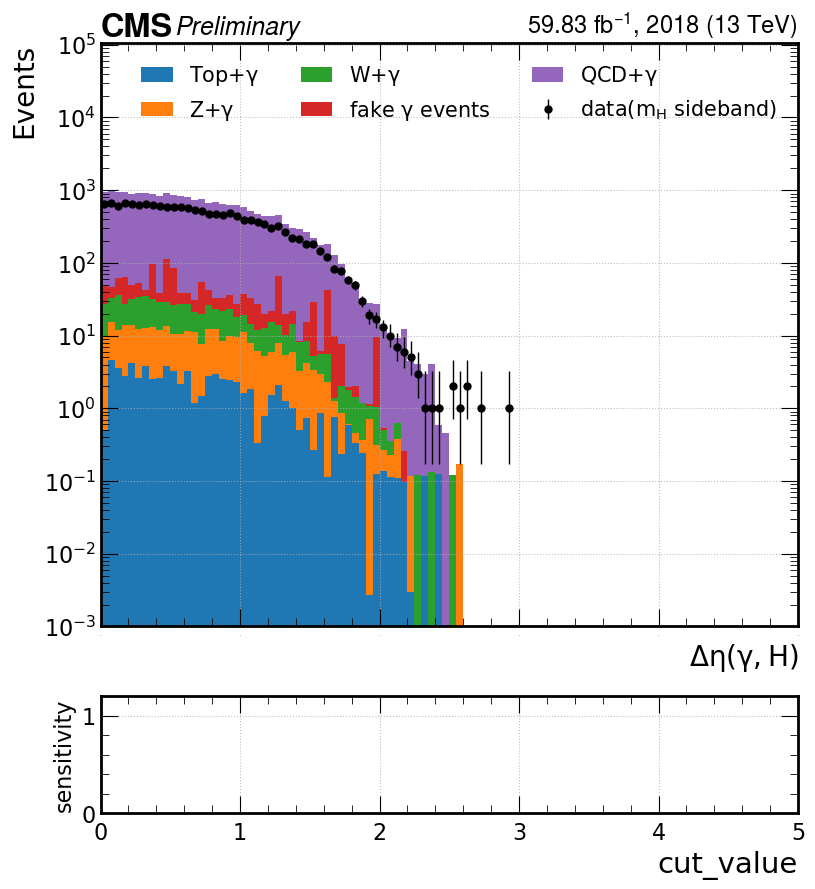

In [24]:
arrays={k: np.abs(events[y][k].photon_eta - events[y][k].AK8jet_eta) for k in events[y]}
optimizing_plot(
    arrays, mode='less', density=False, cuts=eval(
        full_cuts#.replace("&\n((events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] < 0.6))", "")
    ), plot_name='delta_eta_photon_jet', x_name=r'$\Delta\eta(\gamma, H)$', x_max=5, x_min=0, bins=100, weight=weight[y], year=y
)

# With full selection

## $Z^\prime$ mass window

/tmp/ipykernel_2149902/1627673624.py:59: RuntimeWarning:

divide by zero encountered in true_divide

/tmp/ipykernel_2149902/1627673624.py:59: RuntimeWarning:

invalid value encountered in true_divide

/home/fudawei/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:3458: RuntimeWarning:

invalid value encountered in add

/home/fudawei/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning:

invalid value encountered in reduce

/home/fudawei/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning:

invalid value encountered in reduce

/tmp/ipykernel_2149902/1898494878.py:33: RuntimeWarning:

invalid value encountered in true_divide

/tmp/ipykernel_2149902/1898494878.py:50: RuntimeWarning:

invalid value encountered in true_divide

/tmp/ipykernel_2149902/1898494878.py:51: RuntimeWarning:

invalid value encountered in true_divide

/tmp/ipykernel_2149902/1898494878.py:33: RuntimeWarning:

invalid value encountered in true_divide


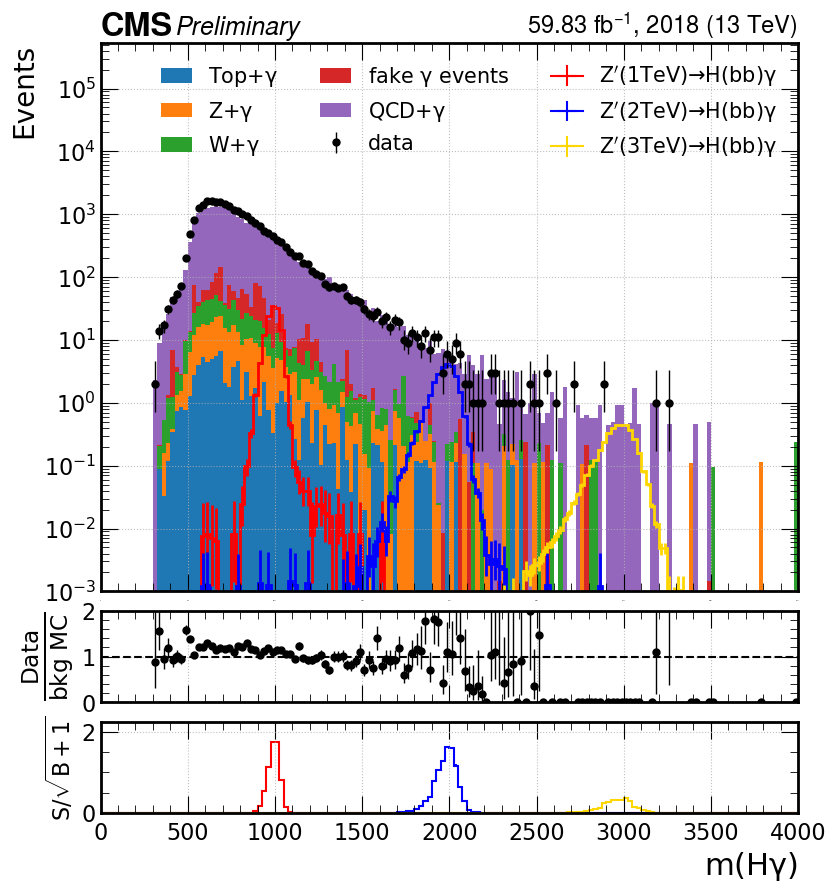

In [ ]:
y = '2018'
arrays={
    k: events[y][k]['photon+jet_mass'][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}
data_mc_compare_plot(arrays, plot_name='full_photon+jet_mass', x_name=r'$m(H\gamma)$', x_max=4000, bins=160, weight=_weight, year=y)

## $m_H$ distribution

$Z^\mathrm{\prime}$(1000)$\to H(bb)\gamma$ [0.19655766 1.37103816 0.12878177]
$Z^\mathrm{\prime}$(2000)$\to H(bb)\gamma$ [0.03809458 0.26485465 0.02592718]
$Z^\mathrm{\prime}$(3000)$\to H(bb)\gamma$ [0.00784935 0.04026622 0.00406284]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'

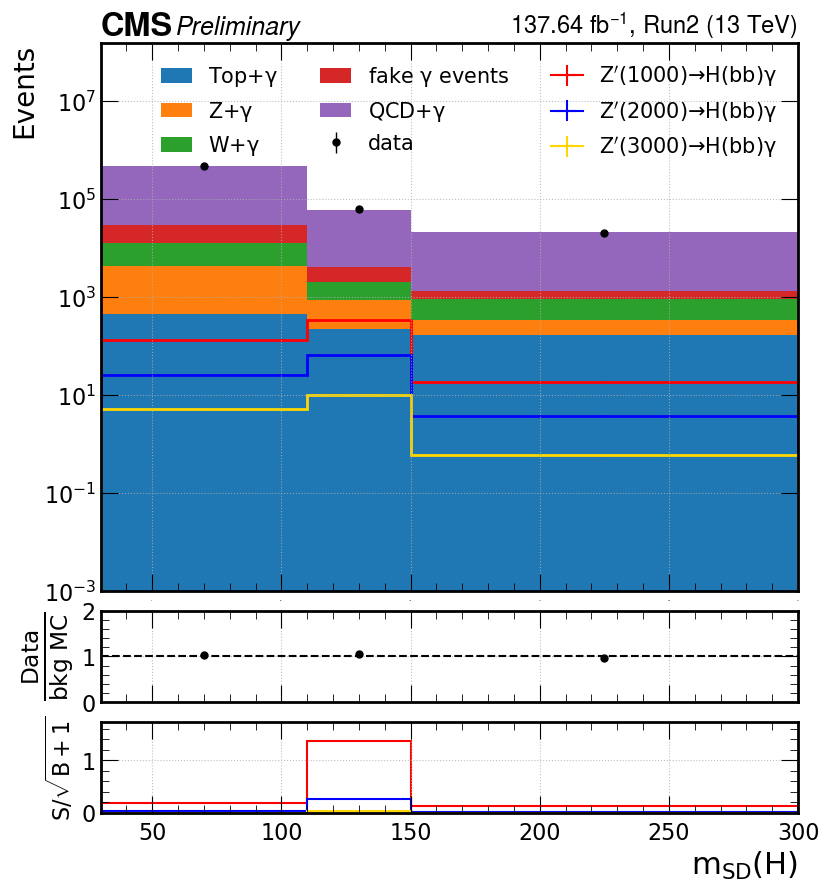

$Z^\mathrm{\prime}$(1000)$\to H(bb)\gamma$ [2.41606399e-02 2.22433374e-02 2.06785934e-02 2.10676952e-02
 1.79338269e-02 2.01586159e-02 1.95772433e-02 2.05977229e-02
 2.61287642e-02 3.30677214e-02 4.08279349e-02 5.76888195e-02
 7.62547620e-02 1.05706553e-01 1.66504752e-01 2.24739544e-01
 3.24653477e-01 4.55856435e-01 6.00753021e-01 6.95936531e-01
 7.01650273e-01 5.60350675e-01 3.75098145e-01 2.02496602e-01
 1.06902057e-01 6.08938548e-02 3.42048295e-02 3.54747550e-02
 2.34678519e-02 1.96712105e-02 1.94522162e-02 1.98502532e-02
 2.11965599e-02 1.60294009e-02 1.52205970e-02 1.13456771e-02
 1.39116044e-02 1.44082826e-02 1.22604758e-02 1.08050272e-02
 1.04792302e-02 8.98372683e-03 8.53093408e-03 6.42555152e-03
 7.06417387e-03 6.57330339e-03 7.74829910e-03 5.65492295e-03
 4.74490811e-03 7.00145483e-03 4.15230179e-03 6.43513580e-04
 1.28139692e-03 5.20285711e-03]
$Z^\mathrm{\prime}$(2000)$\to H(bb)\gamma$ [0.00317313 0.00335574 0.00287699 0.0028991  0.00275745 0.00292017
 0.00341676 0.00383212

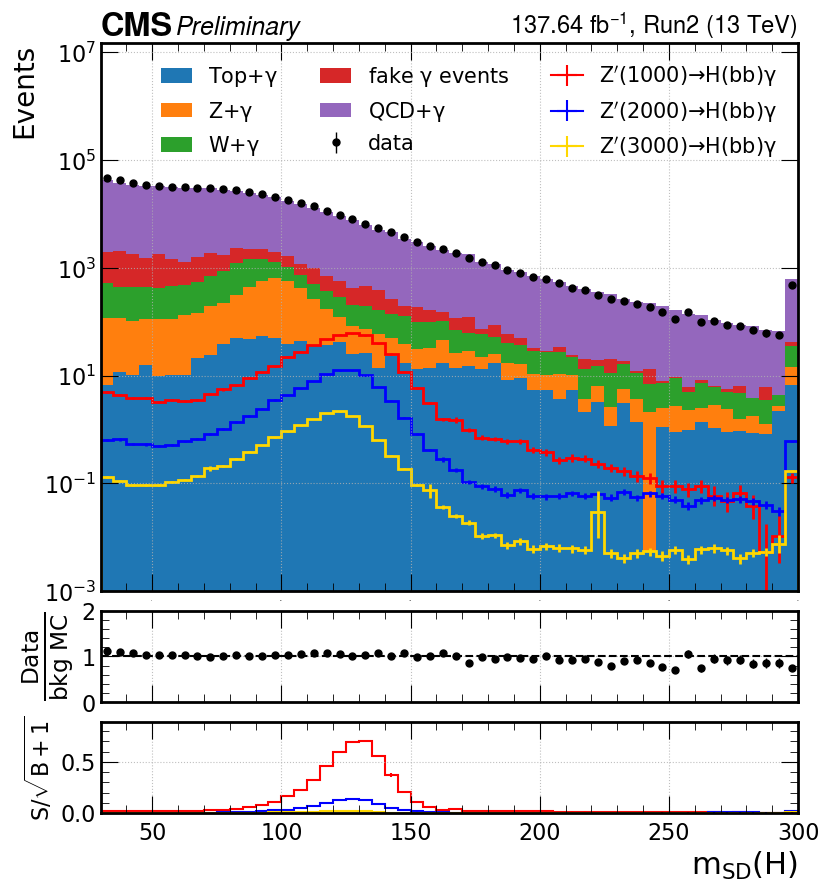

In [10]:
y = 'Run2'
arrays={
    k: events[y][k]['AK8jet_msoftdrop'][
        #(events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        #(events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}
data_mc_compare_plot(arrays, plot_name='full_AK8jet_msoftdrop', x_name=r'$m_{SD}(H)$', x_max=300, x_min=30, bins=54, weight=_weight, year=y, underflow=True, x_axis=bh.axis.Variable([30, 110, 150, 300]))
data_mc_compare_plot(arrays, plot_name='full_AK8jet_msoftdrop_regular', x_name=r'$m_{SD}(H)$', x_max=300, x_min=30, bins=54, weight=_weight, year=y, underflow=True)

$Z^\mathrm{\prime}$(1000)$\to H(bb)\gamma$ [0.13371763 1.48456851 0.23803087]
$Z^\mathrm{\prime}$(2000)$\to H(bb)\gamma$ [0.02078485 0.30670016 0.03784888]
$Z^\mathrm{\prime}$(3000)$\to H(bb)\gamma$ [0.0037046  0.051491   0.00477948]


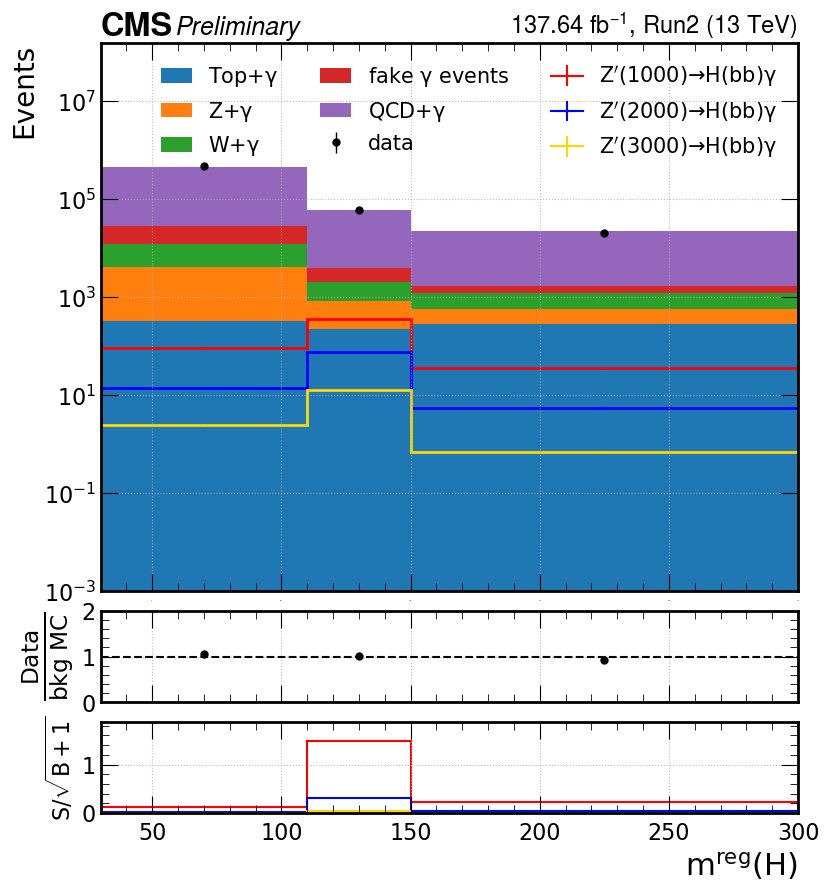

/tmp/ipykernel_3476671/1898494878.py:33: RuntimeWarning: invalid value encountered in true_divide
  number = np.nan_to_num(h**2/var, nan=0)
/tmp/ipykernel_3476671/1898494878.py:50: RuntimeWarning: invalid value encountered in true_divide
  up_error_bar *= np.nan_to_num(var/h, nan=1)
/tmp/ipykernel_3476671/1898494878.py:51: RuntimeWarning: invalid value encountered in true_divide
  down_error_bar *= np.nan_to_num(var/h, nan=1)


$Z^\mathrm{\prime}$(1000)$\to H(bb)\gamma$ [1.88974622e-02 1.43454997e-02 1.43056696e-02 1.53666269e-02
 1.45650872e-02 1.51970457e-02 1.69671309e-02 1.68820776e-02
 1.63433296e-02 2.07913728e-02 2.45934870e-02 3.02921056e-02
 4.57763021e-02 7.02749649e-02 1.07134906e-01 1.76570344e-01
 2.85615465e-01 4.59712343e-01 6.78526942e-01 8.17662462e-01
 7.66671935e-01 6.07863198e-01 3.97202667e-01 2.68564951e-01
 1.66508593e-01 1.15420076e-01 9.05295906e-02 7.29106498e-02
 6.41467157e-02 5.19603608e-02 4.66355669e-02 4.60829116e-02
 3.53389447e-02 3.15524497e-02 2.79302840e-02 2.36130890e-02
 2.08625110e-02 1.22053752e-02 1.03959253e-02 7.40133239e-03
 7.00187353e-03 6.99031634e-03 3.79132905e-03 1.63603250e-03
 1.29558819e-03 1.56754364e-03 0.00000000e+00 2.75567432e-03
 1.57922507e-03 0.00000000e+00 5.96110482e-04 1.46909088e-03
 0.00000000e+00 4.39326971e-04]
$Z^\mathrm{\prime}$(2000)$\to H(bb)\gamma$ [0.00217759 0.00093836 0.00107225 0.00095249 0.00105632 0.00108574
 0.00129008 0.00151161

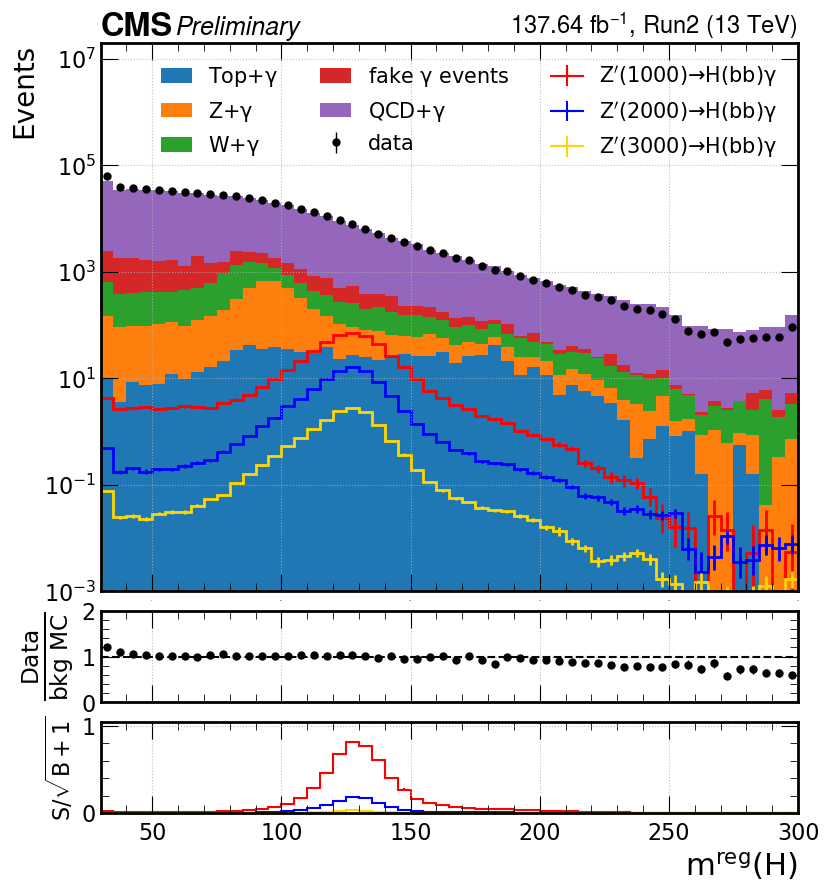

In [11]:
y = 'Run2'
arrays={
    k: events[y][k]['AK8jet_inclParTMDV1_mass'][
        #(events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        #(events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}
data_mc_compare_plot(arrays, plot_name='full_AK8jet_tagger_mass', x_name=r'$m^{reg}(H)$', x_max=300, x_min=30, bins=54, weight=_weight, year=y, underflow=True, x_axis=bh.axis.Variable([30, 110, 150, 300]))
data_mc_compare_plot(arrays, plot_name='full_AK8jet_tagger_mass_regular', x_name=r'$m^{reg}(H)$', x_max=300, x_min=30, bins=54, weight=_weight, year=y, underflow=True)

In [ ]:
ak.mean(
    np.concatenate([arrays[k][(arrays[k]<140)&(arrays[k]>110)] for k in BKG], axis=0), 
    weight=np.concatenate([_weight[k][(arrays[k]<140)&(arrays[k]>110)] for k in BKG], axis=0)
)

122.3700812792263

In [ ]:
ak.mean(
    np.concatenate(
        [arrays[k][((arrays[k]<110)&(arrays[k]>100))|(arrays[k]<60)&(arrays[k]>50)|((arrays[k]<250)&(arrays[k]>140))] for k in BKG], axis=0
    ), weight=np.concatenate(
        [_weight[k][((arrays[k]<110)&(arrays[k]>100))|(arrays[k]<60)&(arrays[k]>50)|((arrays[k]<250)&(arrays[k]>140))] for k in BKG], axis=0
    )
)

94.01987147886541

In [ ]:
hep.style.use("CMS")

def mH_mass_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=False, underflow=False, fraction_log=False):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    plt.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
    
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Variable([100, 110, 140, 170]), storage=bh.storage.Weight())
        if 'delta_phi' in plot_name:
            values = np.min([v, 2*np.pi-v], axis=0)
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var
        
    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=density, stack=True, linewidth=2, ax=ax)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        # we usually don't care error of background MC cuz the stats is very large (relative error is very small compared with signal and data)
    for (k,h) in individual['h'].items():
        if k=='data':
            err = error_bar(h, individual['var'][k], mode='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
        elif k in SIG_COLOR:  # signal
            err = error_bar(h, individual['var'][k], mode='mc')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(bkg_h + 1)
            hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(bkg_h+1), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(0, ax.get_ylim()[1]*1.2)
    #if not density:
    #    ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    
    #ax2.set_yscale('log')
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.2)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$S/\sqrt{B+1}$', ha='center', fontsize=16)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=15)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig(f"./plots/{year}_{plot_name}{suffix}.pdf", bbox_inches='tight')
    plt.show()
    

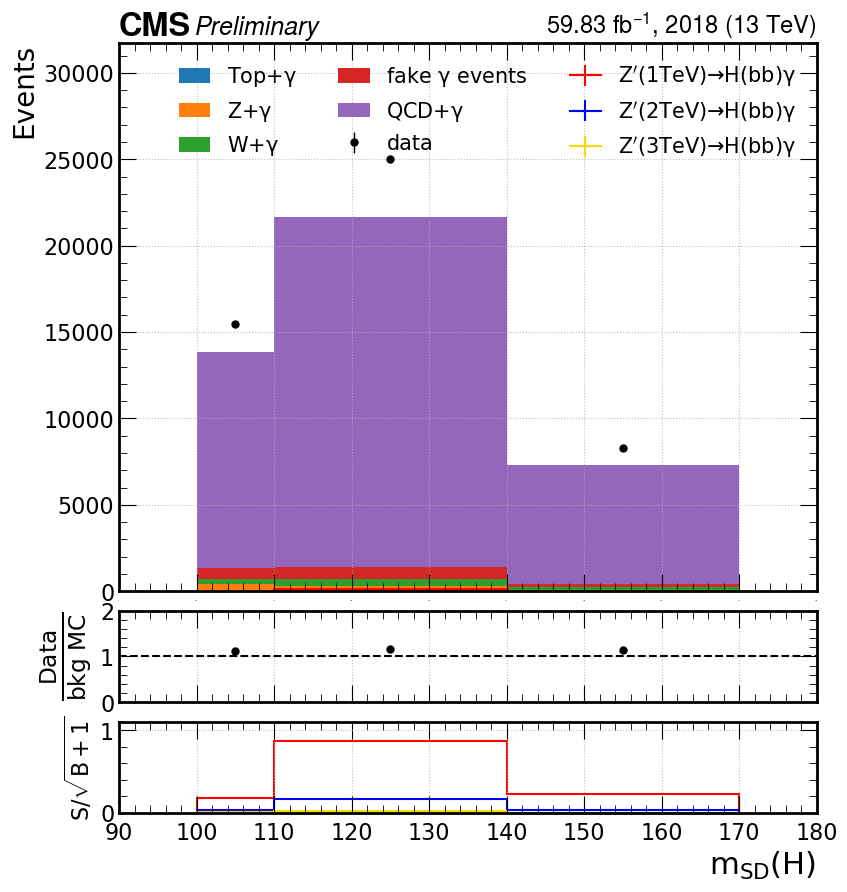

In [ ]:
y = '2018'
arrays={
    k: events[y][k]['AK8jet_msoftdrop'][
        #(events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        #(events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}
mH_mass_plot(arrays, plot_name='mH_in_3_region', x_name=r'$m_{SD}(H)$', x_max=180, x_min=90, bins=54, weight=_weight, year=y)

# Tagger score study and Categorization

In [15]:
score_all = [
    'AK8jet_inclParTMDV1_probHWqqWev0c',
    'AK8jet_inclParTMDV1_probHWqqWev1c',
    'AK8jet_inclParTMDV1_probHWqqWmv0c',
    'AK8jet_inclParTMDV1_probHWqqWmv1c',
    'AK8jet_inclParTMDV1_probHWqqWq0c',
    'AK8jet_inclParTMDV1_probHWqqWq1c',
    'AK8jet_inclParTMDV1_probHWqqWq2c',
    'AK8jet_inclParTMDV1_probHWqqWqq0c',
    'AK8jet_inclParTMDV1_probHWqqWqq1c',
    'AK8jet_inclParTMDV1_probHWqqWqq2c',
    'AK8jet_inclParTMDV1_probHWqqWtauev0c',
    'AK8jet_inclParTMDV1_probHWqqWtauev1c',
    'AK8jet_inclParTMDV1_probHWqqWtauhv0c',
    'AK8jet_inclParTMDV1_probHWqqWtauhv1c',
    'AK8jet_inclParTMDV1_probHWqqWtaumv0c',
    'AK8jet_inclParTMDV1_probHWqqWtaumv1c',
    'AK8jet_inclParTMDV1_probHbb',
    'AK8jet_inclParTMDV1_probHcc',
    'AK8jet_inclParTMDV1_probHqq',
    'AK8jet_inclParTMDV1_probHss',
    'AK8jet_inclParTMDV1_probHtauhtaue',
    'AK8jet_inclParTMDV1_probHtauhtauh',
    'AK8jet_inclParTMDV1_probHtauhtaum',
    'AK8jet_inclParTMDV1_probQCDb',
    'AK8jet_inclParTMDV1_probQCDbb',
    'AK8jet_inclParTMDV1_probQCDc',
    'AK8jet_inclParTMDV1_probQCDcc',
    'AK8jet_inclParTMDV1_probQCDothers',
    'AK8jet_inclParTMDV1_probTopbWev',
    'AK8jet_inclParTMDV1_probTopbWmv',
    'AK8jet_inclParTMDV1_probTopbWq0c',
    'AK8jet_inclParTMDV1_probTopbWq1c',
    'AK8jet_inclParTMDV1_probTopbWqq0c',
    'AK8jet_inclParTMDV1_probTopbWqq1c',
    'AK8jet_inclParTMDV1_probTopbWtauev',
    'AK8jet_inclParTMDV1_probTopbWtauhv',
    'AK8jet_inclParTMDV1_probTopbWtaumv',
]

score_Higgs = [k for k in score_all if k.startswith('AK8jet_inclParTMDV1_probH')]

score_HWW = [
    'AK8jet_inclParTMDV1_probHWqqWev0c',
    'AK8jet_inclParTMDV1_probHWqqWev1c',
    'AK8jet_inclParTMDV1_probHWqqWmv0c',
    'AK8jet_inclParTMDV1_probHWqqWmv1c',
    'AK8jet_inclParTMDV1_probHWqqWq0c',
    'AK8jet_inclParTMDV1_probHWqqWq1c',
    'AK8jet_inclParTMDV1_probHWqqWq2c',
    'AK8jet_inclParTMDV1_probHWqqWqq0c',
    'AK8jet_inclParTMDV1_probHWqqWqq1c',
    'AK8jet_inclParTMDV1_probHWqqWqq2c',
    'AK8jet_inclParTMDV1_probHWqqWtauev0c',
    'AK8jet_inclParTMDV1_probHWqqWtauev1c',
    'AK8jet_inclParTMDV1_probHWqqWtauhv0c',
    'AK8jet_inclParTMDV1_probHWqqWtauhv1c',
    'AK8jet_inclParTMDV1_probHWqqWtaumv0c',
    'AK8jet_inclParTMDV1_probHWqqWtaumv1c',
]

score_QCD = [
    'AK8jet_inclParTMDV1_probQCDb',
    'AK8jet_inclParTMDV1_probQCDbb',
    'AK8jet_inclParTMDV1_probQCDc',
    'AK8jet_inclParTMDV1_probQCDcc',
    'AK8jet_inclParTMDV1_probQCDothers',
]

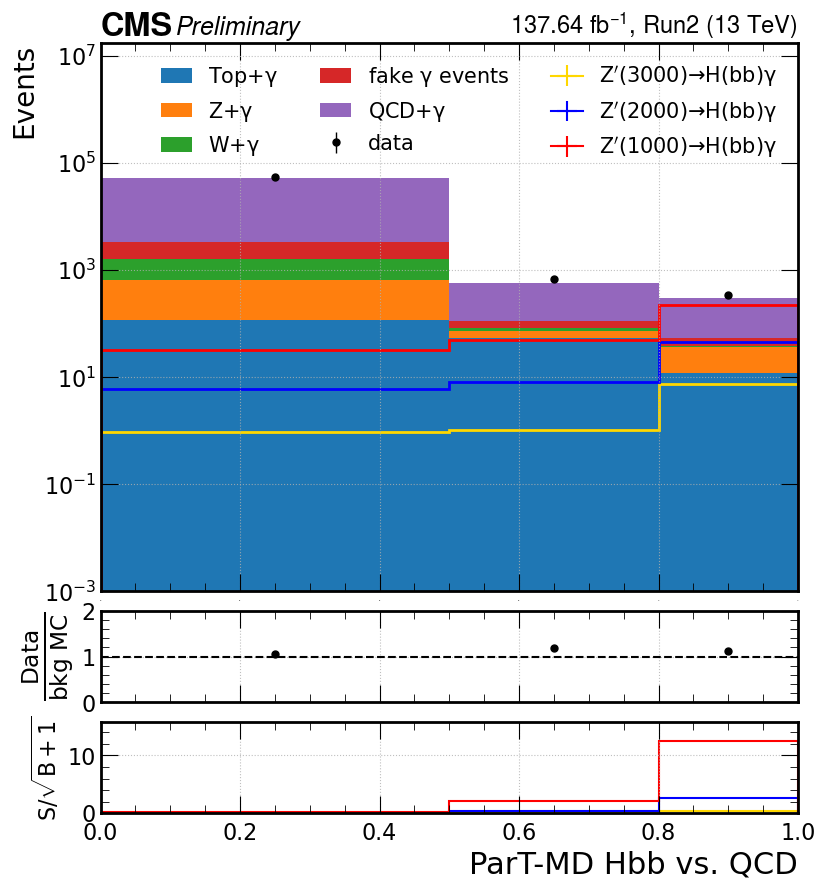

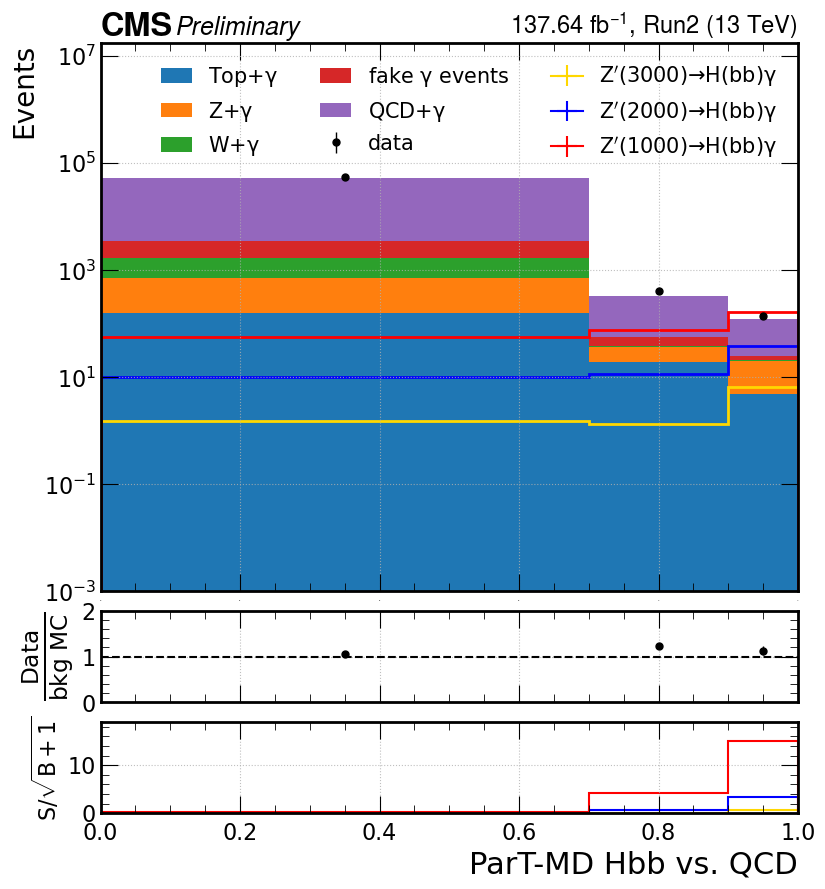

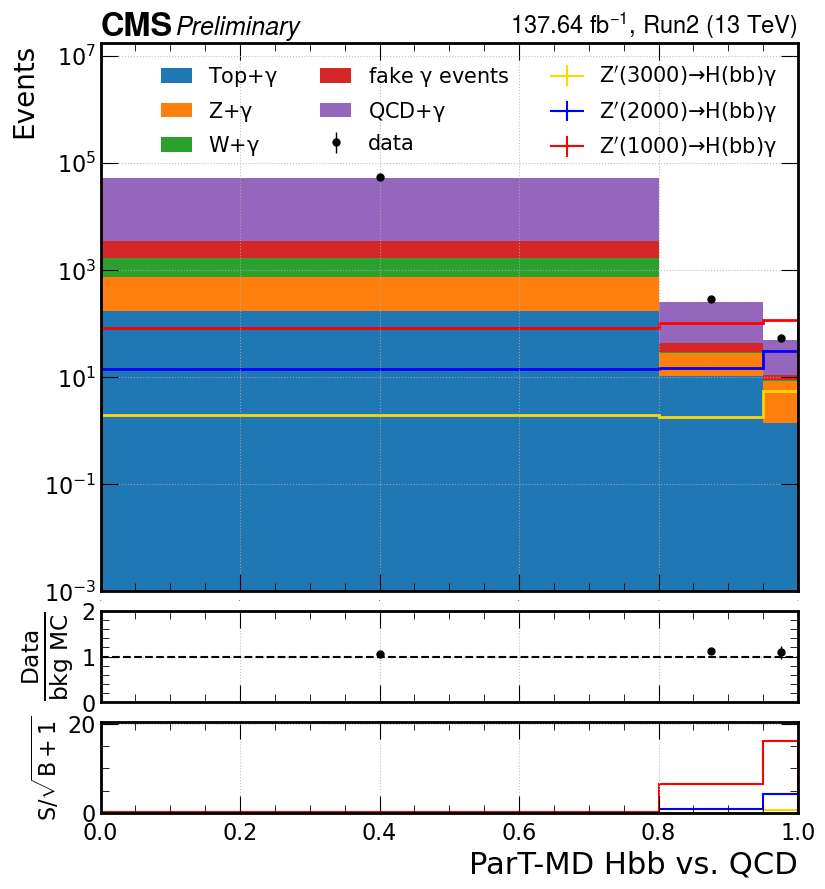

In [20]:
y='Run2'
arrays={
    k: (events[y][k]['AK8jet_inclParTMDV1_probHbb']/ak.sum([getattr(events[y][k], d) for d in ['AK8jet_inclParTMDV1_probHbb']+score_QCD], axis=0))[
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, x_name=r'ParT-MD Hbb vs. QCD', plot_name='AK8jet_Hbb_tagger1', x_max=1, bins=5, weight=_weight, year=y, x_axis=bh.axis.Variable([0, 0.5, 0.8, 1]))
data_mc_compare_plot(arrays, x_name=r'ParT-MD Hbb vs. QCD', plot_name='AK8jet_Hbb_tagger2', x_max=1, bins=5, weight=_weight, year=y, x_axis=bh.axis.Variable([0, 0.7, 0.9, 1]))
data_mc_compare_plot(arrays, x_name=r'ParT-MD Hbb vs. QCD', plot_name='AK8jet_Hbb_tagger3', x_max=1, bins=5, weight=_weight, year=y, x_axis=bh.axis.Variable([0, 0.8, 0.95, 1]))

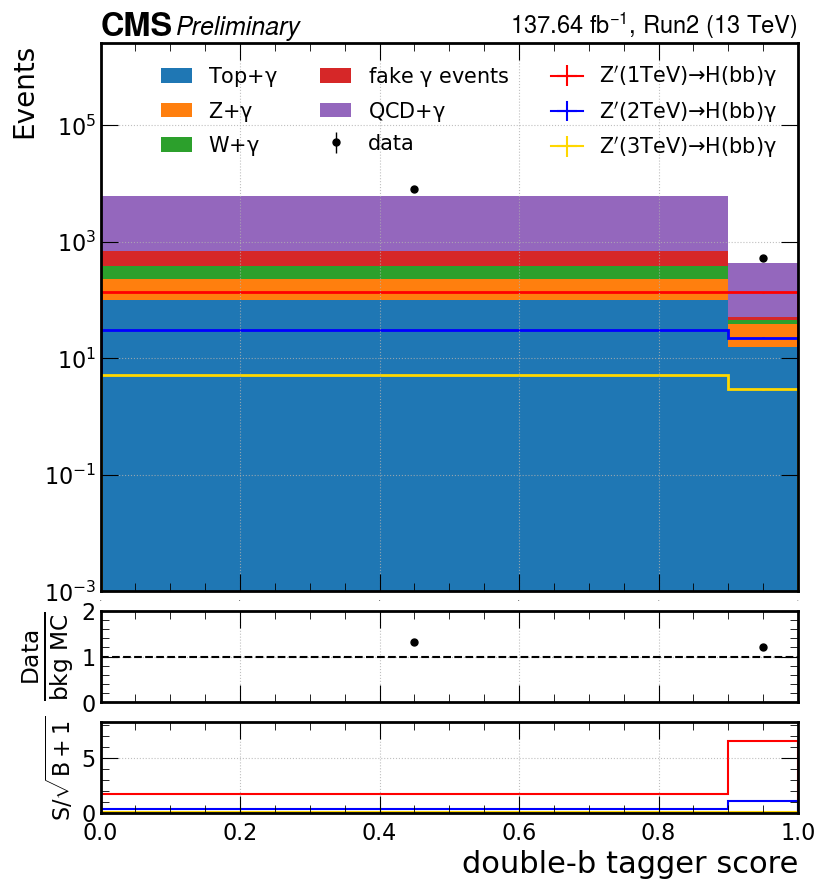

In [29]:
arrays={
    k: getattr(events[y][k], 'AK8jet_btagHbb')[
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, x_name=r'double-b tagger score', plot_name='AK8jet_doubleb_tagger', x_max=1, bins=20, weight=_weight, year=y, x_axis=bh.axis.Variable([0, 0.9, 1]))

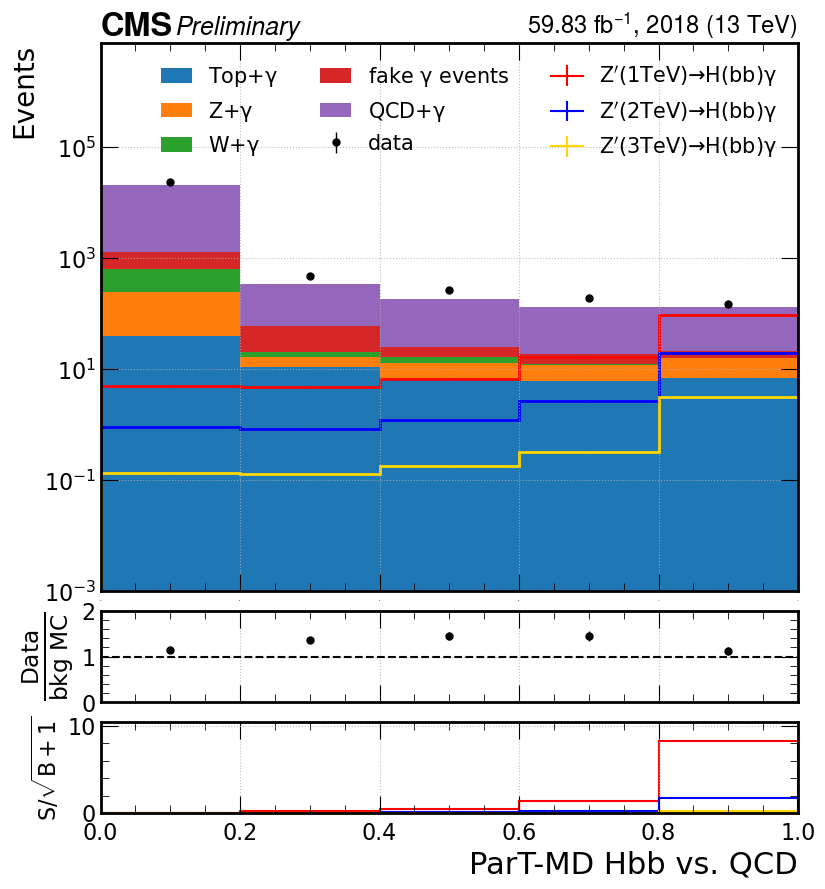

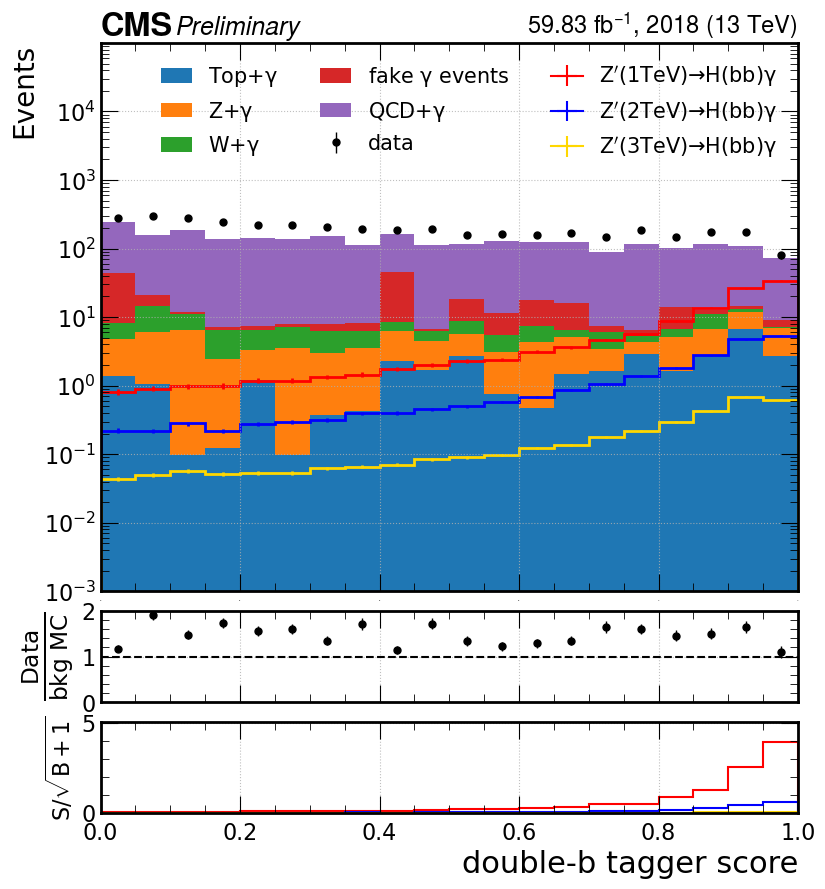

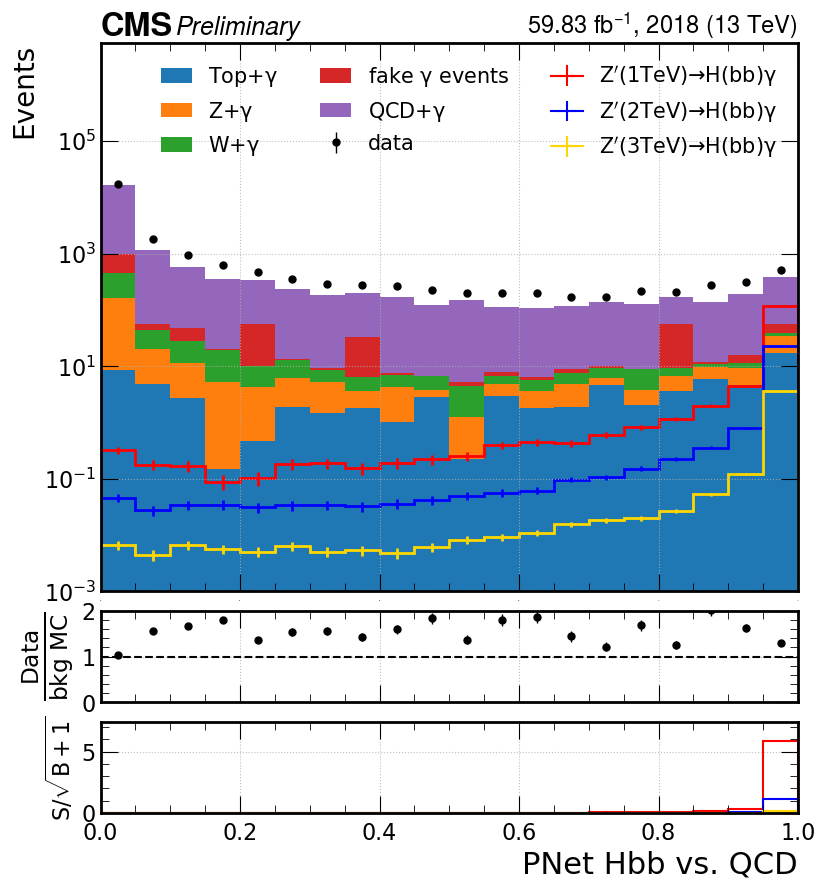

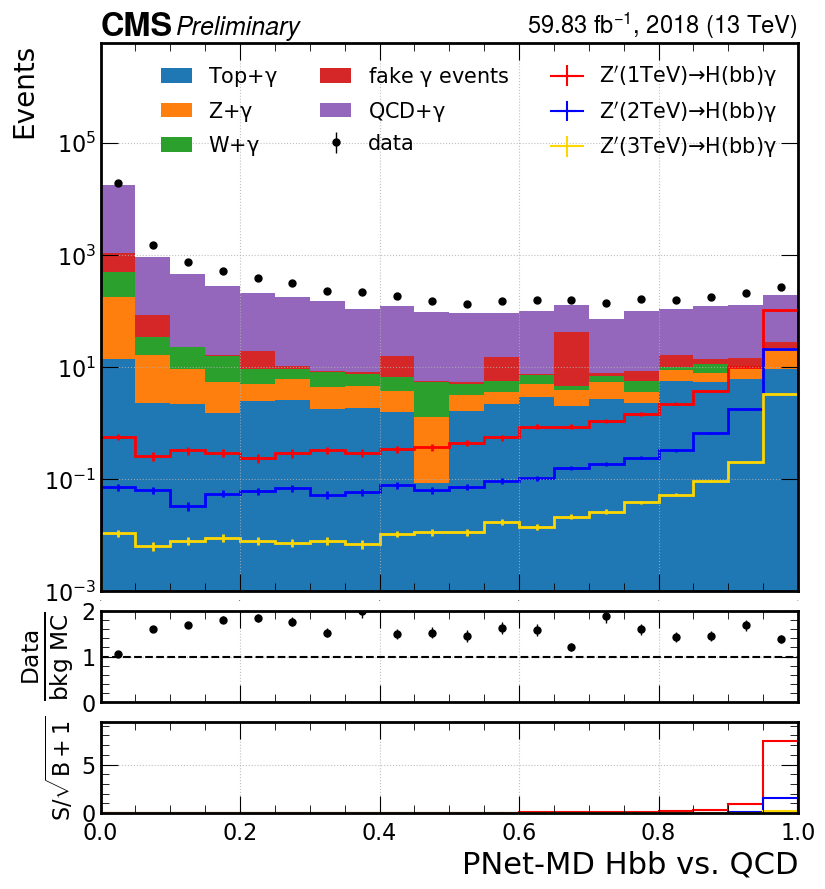

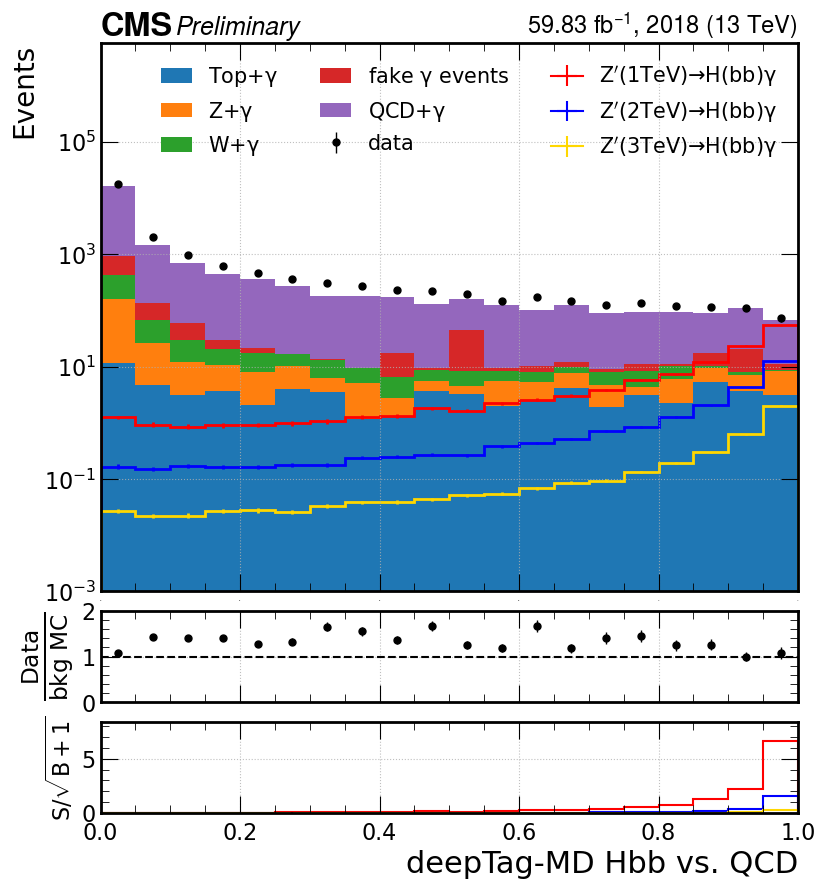

/tmp/ipykernel_2149902/1627673624.py:59: RuntimeWarning:

invalid value encountered in true_divide

/home/fudawei/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning:

invalid value encountered in reduce

/home/fudawei/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning:

invalid value encountered in reduce



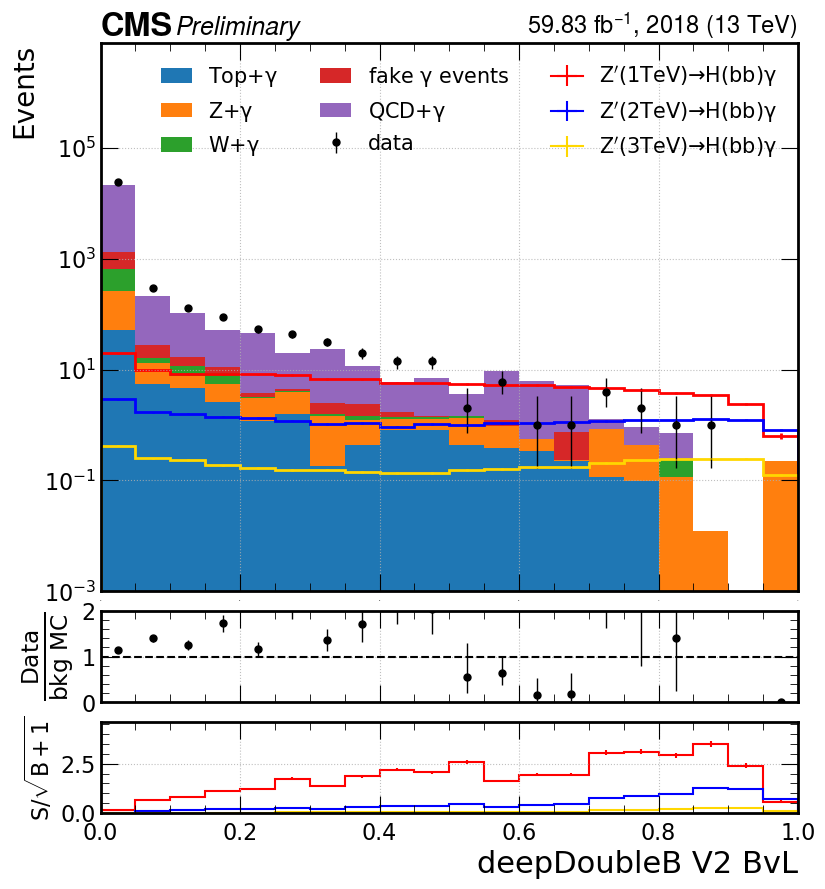

In [30]:
y='2018'
arrays={
    k: (events[y][k]['AK8jet_inclParTMDV1_probHbb']/ak.sum([getattr(events[y][k], d) for d in ['AK8jet_inclParTMDV1_probHbb']+score_QCD], axis=0))[
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, x_name=r'ParT-MD Hbb vs. QCD', plot_name='AK8jet_Hbb_tagger', x_max=1, bins=5, weight=_weight, year=y)

arrays={
    k: getattr(events[y][k], 'AK8jet_btagHbb')[
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, x_name=r'double-b tagger score', plot_name='AK8jet_doubleb_tagger', x_max=1, bins=20, weight=_weight, year=y)


arrays={
    k: events[y][k]['AK8jet_particleNet_HbbvsQCD'][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, x_name=r'PNet Hbb vs. QCD', plot_name='AK8jet_ParticleNet', x_max=1, bins=20, weight=_weight, year=y)

arrays={
    k: (events[y][k]['AK8jet_particleNetMD_Xbb']/(events[y][k]['AK8jet_particleNetMD_Xbb']+events[y][k]['AK8jet_particleNetMD_QCD']))[
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, x_name=r'PNet-MD Hbb vs. QCD', plot_name='AK8jet_ParticleNet-MD', x_max=1, bins=20, weight=_weight, year=y)

arrays={
    k: events[y][k]['AK8jet_deepTagMD_HbbvsQCD'][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, x_name=r'deepTag-MD Hbb vs. QCD', plot_name='AK8jet_deepTag-MD', x_max=1, bins=20, weight=_weight, year=y)

arrays={
    k: events[y][k]['AK8jet_btagDDBvLV2'][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}

data_mc_compare_plot(arrays, x_name=r'deepDoubleB V2 BvL', plot_name='AK8jet_deepDoubleB', x_max=1, bins=20, weight=_weight, year=y)


In [31]:
def tagger_study_plot(arrays, weight, plot_name: str, x_name: str, cuts=None, year='2018', bins=40, x_min=0, x_max=2000, density=False, overflow=True, underflow=False, fraction_log=False):
    LUMI = {"2016pre": 19.52, "2016post": 16.81, "2017": 41.48, "2018": 59.83,}
    bin_width = (x_max-x_min)/bins
    if cuts:
        arrays = {k: v[cuts[k]] for k, v in arrays.items()}
        
    ## canvas initializing
    # f, ax = plt.subplots()
    f = plt.figure(figsize=(9, 10))
    gs = mpl.gridspec.GridSpec(3, 1, height_ratios=[6, 1, 1], hspace=0.08)
    ax = f.add_subplot(gs[0])
    #ax = plt.gca()
    plt.grid()
    hep.cms.label(data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')
    ## Ratio panel
    ax1 = f.add_subplot(gs[1])
    ax2 = f.add_subplot(gs[2])
    ax1.grid()
    ax2.grid()
    
    ## analyze
    stacked = {'h': {}, 'var': {}}
    individual = {'h': {}, 'var': {}}
    
    for (k,v) in arrays.items():
        hist = bh.Histogram(bh.axis.Regular(bins, x_min, x_max), storage=bh.storage.Weight())
        if 'delta_phi' in plot_name:
            values = np.min([v, 2*np.pi-v], axis=0)
        values = ak.fill_none(v, -999)
        
        if k!='data' and weight is not None:
            hist.fill(values, weight=weight[k])
        else:
            hist.fill(values)
        h, var = flow(hist=hist, overflow=overflow, underflow=underflow)
        
        if k in BKG: 
            stacked['h'][k] = h
            stacked['var'][k] = var
        else:
            individual['h'][k] = h
            individual['var'][k] = var
        
    ## plot
    ax1.plot([x_min,x_max], [1,1], color='black', linestyle='dashed')
    # or you can specify color='blue' in the above function to cover colorlist (you could comment out colorlist too)
    if len(stacked['h'].keys())>0:
        hep.histplot(list(stacked['h'].values()), bins=hist.axes[0].edges, label=list(stacked['h'].keys()), histtype='fill', density=density, stack=True, linewidth=2, ax=ax)
        bkg_h = np.sum(list(stacked['h'].values()), axis=0)
        # we usually don't care error of background MC cuz the stats is very large (relative error is very small compared with signal and data)
    
    combined_significance = {}
    stats_data = {}
    for (k,h) in individual['h'].items():
        if k=='data':
            err = error_bar(h, individual['var'][k], mode='data')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, color='black', histtype='errorbar', density=density, stack=False, ax=ax)
            hep.histplot(h/bkg_h, bins=hist.axes[0].edges, yerr=err/bkg_h, color='black', histtype='errorbar', density=density, stack=False, ax=ax1)
        elif k in SIG_COLOR:  # signal
            err = error_bar(h, individual['var'][k], mode='mc')
            hep.histplot(h, bins=hist.axes[0].edges, yerr=err, label=k, histtype='step', density=density, stack=False, linewidth=2, ax=ax, color=SIG_COLOR[k])
            y = h / np.sqrt(individual['h']['data'])
            hep.histplot(y, bins=hist.axes[0].edges, yerr=err/np.sqrt(individual['h']['data']), label=k, histtype='step', density=density, stack=False, ax=ax2, color=SIG_COLOR[k])
            combined_significance[k] = {
                hist.axes[0].edges[i]: np.sqrt(
                    np.sum(h[:i])**2 / (np.sum(individual['h']['data'][:i])+1e-6) + 
                    np.sum(h[i:])**2 / np.sum(individual['h']['data'][i:])
                ) for i in range(len(h))
            }
            stats_data[k] = {
                np.sum(hist.axes[0].edges[i]): np.sum(individual['h']['data'][i:]) for i in range(len(h))
            }


    ## axises
    ax.set_xlim(x_min, x_max)
    # ax.set_xticklabels([])
    ax.set_ylim(1e-3 if not density else 0, ax.get_ylim()[1]*(1e2 if not density else 1.2))
    if not density:
        ax.set_yscale('log')
    # ax.ticklabel_format(useOffset=False, style='scientific')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='x', which='major', labelsize=0)
    # x_major_locator=plt.MultipleLocator(bin_width*8 if variable=='fj_gen_mass' else bin_width*2)
    # y_major_locator=MultipleLocator(1)
    # ax.xaxis.set_major_locator(x_major_locator)
    # ax.yaxis.set_major_locator(y_major_locator)
    if density==False:
        ax.set_ylabel('Events', fontsize=20, ha='right', y=1)
    elif density==True:    
        ax.set_ylabel('A.U.', fontsize=20, ha='right', y=1)
    
    ax1.set_xlim(x_min, x_max)
    ax1.set_xticklabels([])
    if fraction_log:
        ax1.set_ylim(1e-1, 1e1)
        ax1.set_yscale('log')
    else:
        ax1.set_ylim(0, 2)
    ax1.set_ylabel(r'$\frac{Data}{bkg\ MC}$', ha='center', fontsize=24)
    #ax1.ticklabel_format(useOffset=False, style='plain')
    ax1.tick_params(axis='both', which='major', labelsize=16)
    
    #ax2.set_yscale('log')
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(0, ax2.get_ylim()[1]*1.2)
    ax2.tick_params(axis='both', which='major', labelsize=16)
    ax2.set_xlabel(x_name, fontsize=22, ha='right', x=1)
    ax2.set_ylabel(r'$\frac{signal}{\sqrt{data}}$', ha='center', fontsize=22)
    ax2.ticklabel_format(useOffset=False, style='plain')
    ax2.tick_params(axis='both', which='major', labelsize=16)

    plt.xticks(size=16)
    plt.yticks(size=16)

    ## title, text and legend
    # plt.title('ROC Curve of HWW4q vs. QCD', fontsize=24,color="black")
    ax.legend(loc="best", ncol=3, frameon=False, fontsize=15)
    # plt.text(0.96*ax.get_xlim()[1], ax.get_ylim()[1]*0.72,"At "+r"$\mathrm{m^{gen}_{H}=}$"+f"{Higgsmass} GeV", fontsize=24, color="black", ha='right')

    ## finalizing
    suffix = '_AU' if density else ''
    if not os.path.exists('./plots/tagger'):
        os.makedirs('./plots/tagger')
    plt.savefig(f"./plots/tagger/{year}_{plot_name}{suffix}.pdf", bbox_inches='tight')
    plt.show()
    
    return combined_significance, stats_data

/tmp/ipykernel_2149902/3707736247.py:62: RuntimeWarning:

divide by zero encountered in true_divide

/tmp/ipykernel_2149902/3707736247.py:63: RuntimeWarning:

divide by zero encountered in true_divide

/home/fudawei/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:3458: RuntimeWarning:

invalid value encountered in add

/home/fudawei/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:44: RuntimeWarning:

invalid value encountered in reduce

/home/fudawei/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:40: RuntimeWarning:

invalid value encountered in reduce

/tmp/ipykernel_2149902/3707736247.py:67: RuntimeWarning:

divide by zero encountered in double_scalars

/tmp/ipykernel_2149902/3707736247.py:62: RuntimeWarning:

divide by zero encountered in true_divide

/tmp/ipykernel_2149902/3707736247.py:63: RuntimeWarning:

divide by zero encountered in true_divide

/home/fudawei/anaconda3/lib/python3.9/site-packages/matplotlib/axes/_axes.py:3458: RuntimeWa

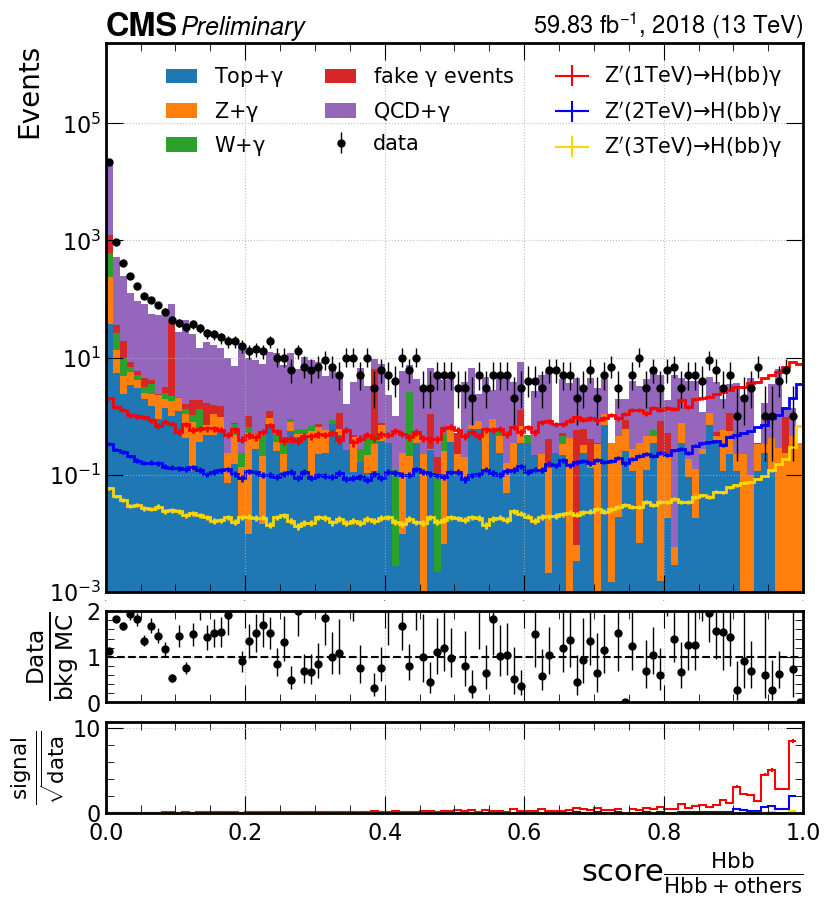

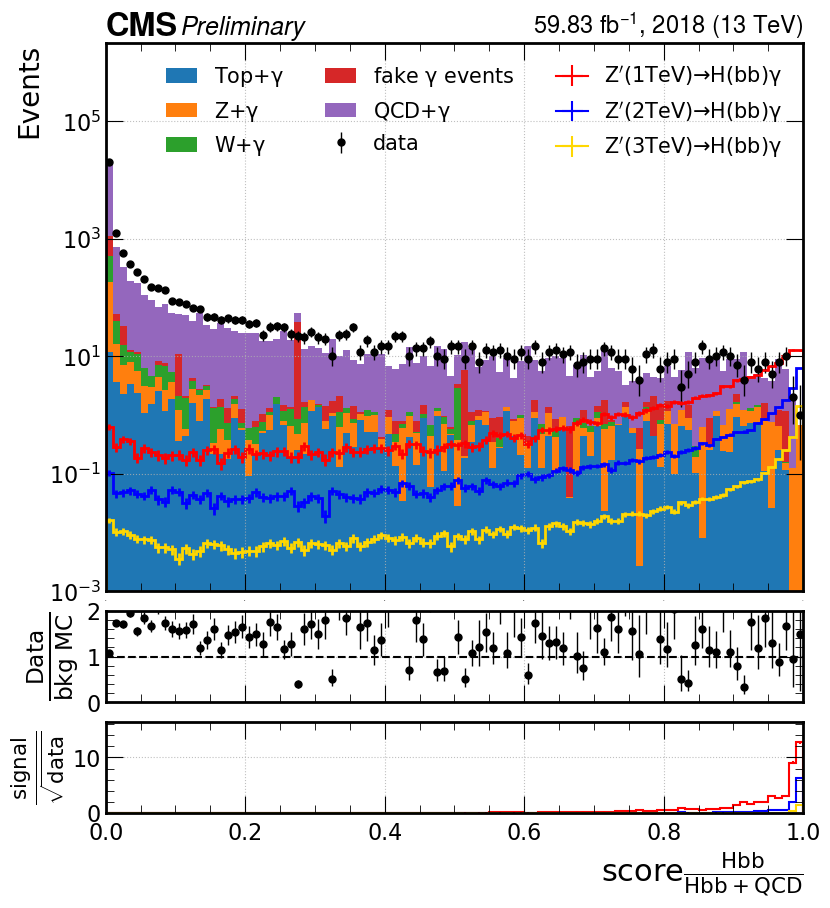

In [32]:
arrays={
    k: getattr(events[y][k], 'AK8jet_inclParTMDV1_probHbb')[
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}
CS_others, stats_others = tagger_study_plot(arrays, plot_name='score(Hbb vs others)', x_name=r'score$\frac{Hbb}{Hbb+others}$', x_max=1, x_min=0, bins=100, weight=_weight, year=y, density=False)

arrays={
    k: (getattr(events[y][k], 'AK8jet_inclParTMDV1_probHbb') / ak.sum([getattr(events[y][k], d) for d in ['AK8jet_inclParTMDV1_probHbb']+score_QCD], axis=0))[
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in events[y]
}
_weight = {
    k: weight[y][k][
        (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140) &
        (np.abs(events[y][k].photon_eta) < 1.4442) &
        (np.abs(events[y][k].AK8jet_eta) < 2.4) &
        (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35)
    ] for k in weight[y]
}
CS_QCD, stats_QCD = tagger_study_plot(arrays, plot_name='score(Hbb vs QCD)', x_name=r'score$\frac{Hbb}{Hbb+QCD}$', x_max=1, x_min=0, bins=100, weight=_weight, year=y, density=False)

In [33]:
a=zip(CS_QCD['$Z^\\mathrm{\\prime}(1TeV)\\to H(bb)\\gamma$'].keys(), CS_QCD['$Z^\\mathrm{\\prime}(1TeV)\\to H(bb)\\gamma$'].values())

In [34]:
for x, cs in sorted(a, key=lambda x: x[1], reverse=True):
    print(x, round(cs, 3), stats_QCD['$Z^\\mathrm{\\prime}(1TeV)\\to H(bb)\\gamma$'][x])

0.98 14.748 3.0
0.99 12.701 1.0
0.97 9.858 13.0
0.95 9.838 26.0
0.93 9.621 40.0
0.91 9.618 52.0
0.94 9.613 34.0
0.9 9.535 59.0
0.96 9.458 21.0
0.92 9.422 48.0
0.89 9.188 69.0
0.88 8.821 81.0
0.87 8.571 91.0
0.86 8.395 100.0
0.85 8.026 115.0
0.82 7.981 131.0
0.84 7.94 123.0
0.83 7.93 128.0
0.81 7.862 140.0
0.8 7.765 148.0
0.79 7.731 154.0
0.78 7.527 167.0
0.77 7.381 178.0
0.76 7.379 182.0
0.75 7.326 188.0
0.74 7.23 197.0
0.73 7.143 206.0
0.72 7.006 218.0
0.71 6.86 232.0
0.7 6.778 241.0
0.69 6.703 250.0
0.68 6.65 258.0
0.67 6.607 265.0
0.66 6.497 277.0
0.65 6.407 288.0
0.64 6.3 301.0
0.63 6.209 313.0
0.62 6.163 321.0
0.61 6.046 336.0
0.6 5.984 345.0
0.59 5.906 357.0
0.58 5.855 366.0
0.57 5.801 376.0
0.56 5.726 389.0
0.55 5.665 401.0
0.54 5.594 414.0
0.53 5.555 422.0
0.52 5.472 437.0
0.51 5.432 446.0
0.5 5.357 461.0
0.49 5.287 476.0
0.48 5.251 485.0
0.47 5.209 495.0
0.46 5.127 513.0
0.45 5.069 527.0
0.44 5.017 541.0
0.43 4.985 551.0
0.42 4.898 573.0
0.41 4.819 595.0
0.4 4.769 610.0
0.39 4

In [35]:
stats_QCD['$Z^\\mathrm{\\prime}(1TeV)\\to H(bb)\\gamma$'][0.9], stats_QCD['$Z^\\mathrm{\\prime}(1TeV)\\to H(bb)\\gamma$'][0.98]

(59.0, 3.0)

In [36]:
stats_others['$Z^\\mathrm{\\prime}(1TeV)\\to H(bb)\\gamma$'][0.9]

26.0

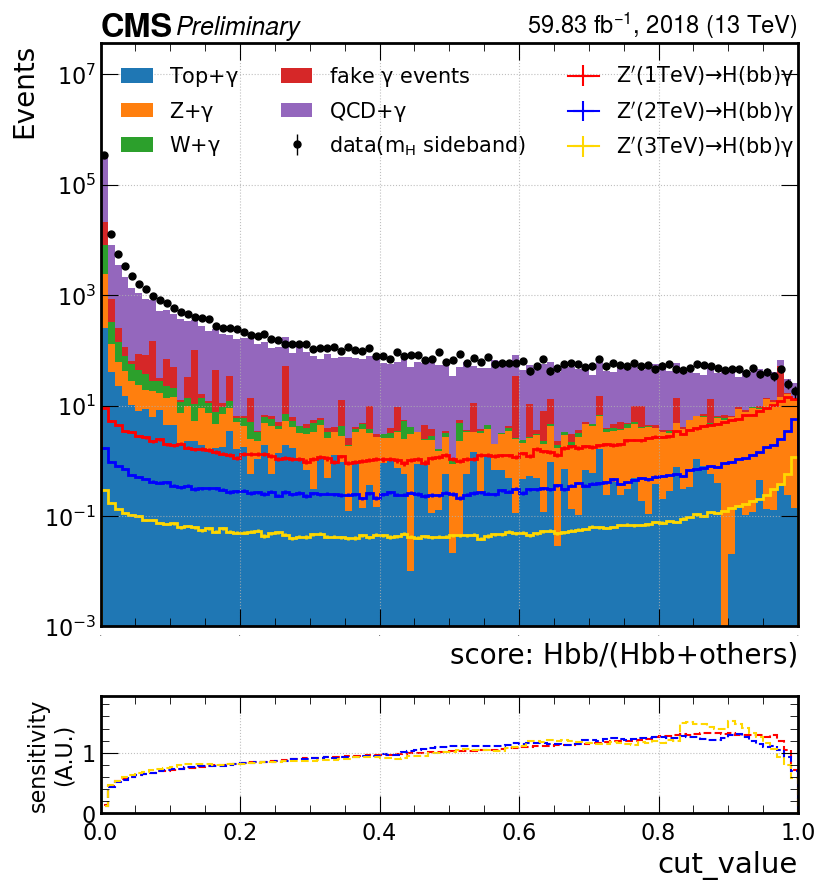

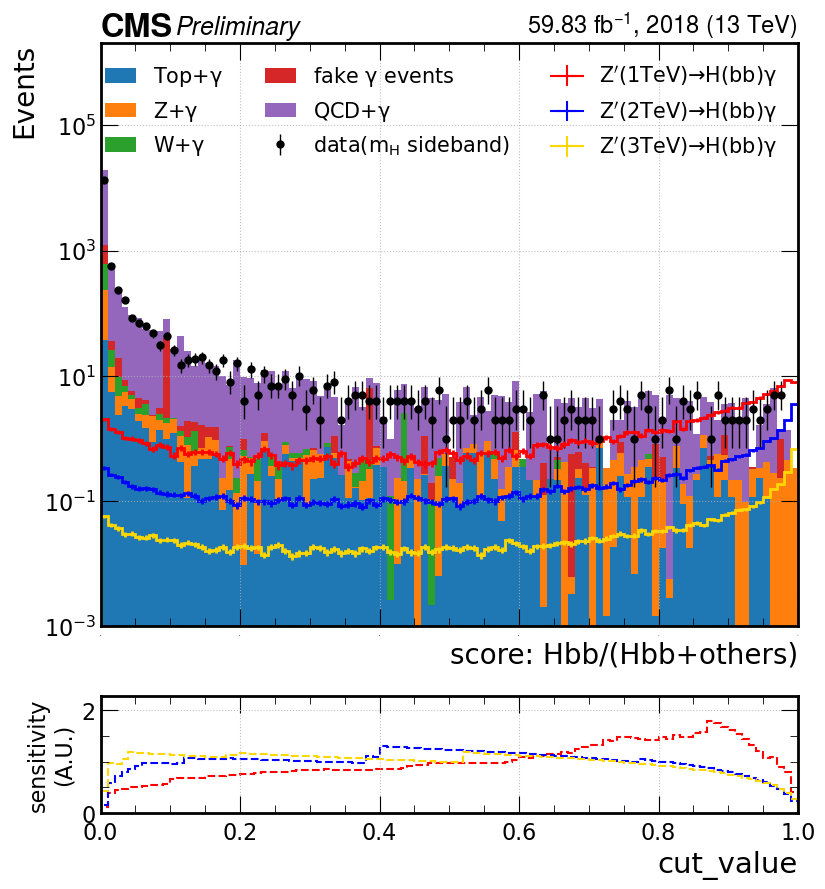

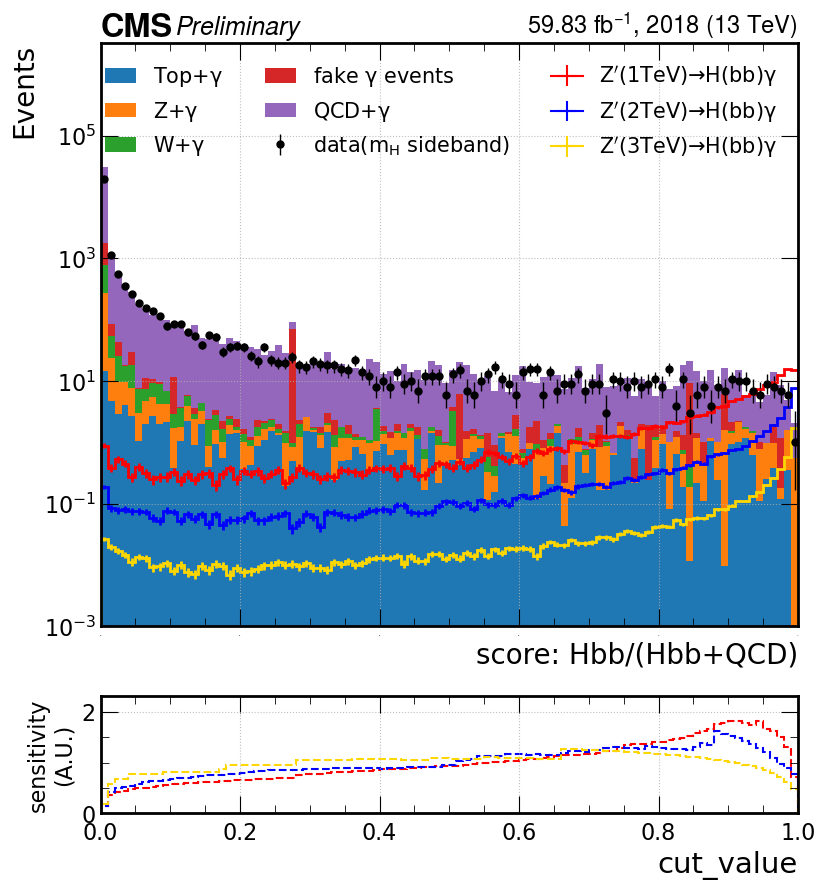

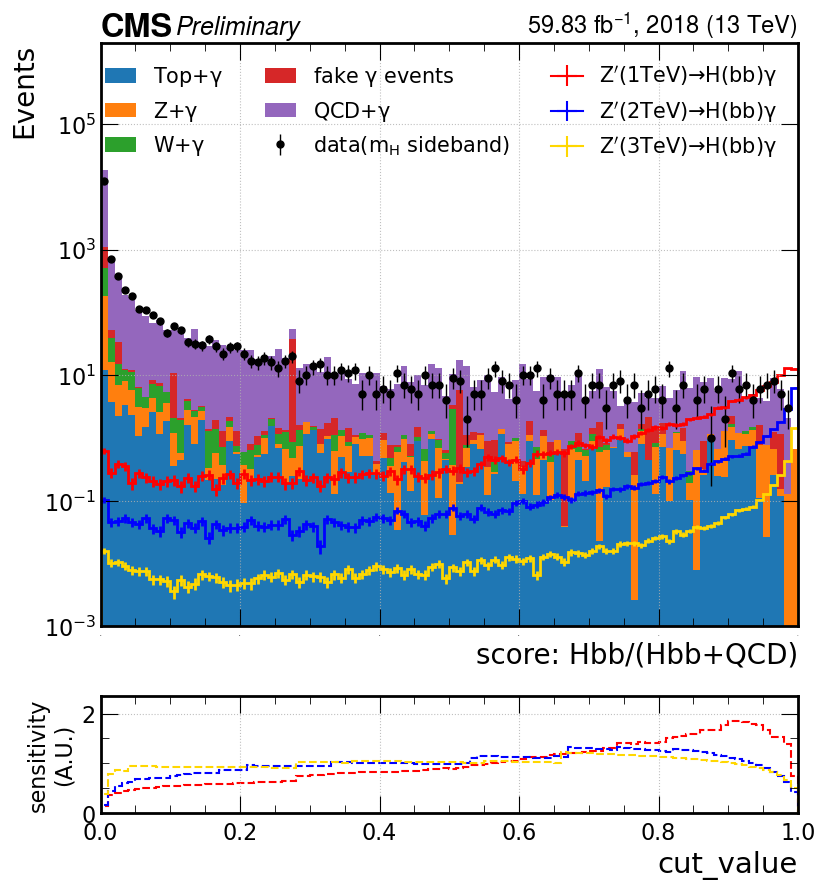

In [37]:
arrays={k: events[y][k].AK8jet_inclParTMDV1_probHbb for k in events[y]}
optimizing_plot(arrays, cuts=None, mode='greater', plot_name='pre_Hbb_score', x_name=r'score: Hbb/(Hbb+others)', x_max=1, x_min=0, bins=100, weight=weight[y], year=y)
optimizing_plot(arrays, cuts=eval(full_cuts), mode='greater', plot_name='Hbb_score', x_name=r'score: Hbb/(Hbb+others)', x_max=1, x_min=0, bins=100, weight=weight[y], year=y)

arrays={
    k: getattr(events[y][k], 'AK8jet_inclParTMDV1_probHbb') / ak.sum([getattr(events[y][k], d) for d in ['AK8jet_inclParTMDV1_probHbb']+score_QCD], axis=0)
    for k in events[y]
}
optimizing_plot(arrays, cuts={
    k: ((events[y][k]['AK8jet_msoftdrop'] > 100) & (events[y][k]['AK8jet_msoftdrop'] < 110) if k=='data' else (events[y][k]['AK8jet_msoftdrop'] > 110) & (events[y][k]['AK8jet_msoftdrop'] < 140))
    for k in arrays
}, mode='greater', plot_name='pre_Hbb_vs_QCD_score', x_name=r'score: Hbb/(Hbb+QCD)', x_max=1, x_min=0, bins=100, weight=weight[y], year=y)
optimizing_plot(arrays, cuts=eval(full_cuts), mode='greater', plot_name='Hbb_vs_QCD_score', x_name=r'score: Hbb/(Hbb+QCD)', x_max=1, x_min=0, bins=100, weight=weight[y], year=y)

# Output

In [9]:
for y in events:
    for k in events[y]:
        if 'H(bb)' not in k:
            continue
        mass = k.split('(')[1].split(')')[0]
        cut = "((np.abs(events[y][k].photon_eta) < 1.4442) & (np.abs(events[y][k].AK8jet_eta) < 2.4) & (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35) & (events[y][k].event_final_weight<10*ak.mean(events[y][k].event_final_weight)))"

        out_tree = {
            "mass_Zprime": events[y][k]['photon+jet_mass'][eval(cut)],
            "mass_Higgs": events[y][k]['AK8jet_msoftdrop'][eval(cut)],
            "weight": events[y][k]['event_final_weight'][eval(cut)],
            "tagger_Hbb": (events[y][k]['AK8jet_inclParTMDV1_probHbb']/ak.sum([getattr(events[y][k], d) for d in ['AK8jet_inclParTMDV1_probHbb']+score_QCD], axis=0))[eval(cut)],
        }

        out_tree = ak.Array({k: np.array(v) for k, v in out_tree.items()})

        if not os.path.exists(f'./fit/input/{y}'):
            os.makedirs(f'./fit/input/{y}')
        with uproot.recreate(f'./fit/input/{y}/mc_signal_Hbb_{mass}.root') as file:
            file['Events'] = out_tree

In [10]:
k = 'data'
for y in events:
    cut = "((np.abs(events[y][k].photon_eta) < 1.4442) & (np.abs(events[y][k].AK8jet_eta) < 2.4) & (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35))"
    out_tree = {
        "mass_Zprime": events[y][k]['photon+jet_mass'][eval(cut)],
        "mass_Higgs": events[y][k]['AK8jet_msoftdrop'][eval(cut)],
        "weight": np.ones_like(events[y][k]['photon+jet_mass'])[eval(cut)],
        "tagger_Hbb": (events[y][k]['AK8jet_inclParTMDV1_probHbb']/ak.sum([getattr(events[y][k], d) for d in ['AK8jet_inclParTMDV1_probHbb']+score_QCD], axis=0))[eval(cut)],
    }

    out_tree = ak.Array({k: np.array(v) for k, v in out_tree.items()})

    if not os.path.exists(f'./fit/input/{y}'):
        os.makedirs(f'./fit/input/{y}')
    with uproot.recreate(f'./fit/input/{y}/data_Hbb.root') as file:
        file['Events'] = out_tree

In [11]:
BKG

{'QCD+$\\gamma$',
 'Top+$\\gamma$',
 'W+$\\gamma$',
 'Z+$\\gamma$',
 'fake $\\gamma$ events'}

In [12]:
for y in events:
    out_tree = {
        "mass_Zprime": ak.concatenate([events[y][k]['photon+jet_mass'][
            ((np.abs(events[y][k].photon_eta) < 1.4442) & (np.abs(events[y][k].AK8jet_eta) < 2.4) & (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35))
        ] for k in BKG], axis=0),
        "mass_Higgs": ak.concatenate([events[y][k]['AK8jet_msoftdrop'][
            ((np.abs(events[y][k].photon_eta) < 1.4442) & (np.abs(events[y][k].AK8jet_eta) < 2.4) & (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35))
        ] for k in BKG], axis=0),
        "weight": ak.concatenate([events[y][k]['event_final_weight'][
            ((np.abs(events[y][k].photon_eta) < 1.4442) & (np.abs(events[y][k].AK8jet_eta) < 2.4) & (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35))
        ] for k in BKG], axis=0),
        "tagger_Hbb": ak.concatenate(
            [(events[y][k]['AK8jet_inclParTMDV1_probHbb']/ak.sum([getattr(events[y][k], d) for d in ['AK8jet_inclParTMDV1_probHbb']+score_QCD], axis=0))[
                ((np.abs(events[y][k].photon_eta) < 1.4442) & (np.abs(events[y][k].AK8jet_eta) < 2.4) & (events[y][k].photon_pt/events[y][k]['photon+jet_mass'] > 0.35))
            ] for k in BKG], axis=0
        ),
    }

    out_tree = ak.Array({k: np.array(v) for k, v in out_tree.items()})

    if not os.path.exists(f'./fit/input/{y}'):
        os.makedirs(f'./fit/input/{y}')
    with uproot.recreate(f'./fit/input/{y}/mc_background.root') as file:
        file['Events'] = out_tree